In [1]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


# 1.Import libraries

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates

import os
import sqlite3
import math
from collections import Counter
from pathlib import Path
from tqdm import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

from scipy.stats import skew
import yellowbrick
import sklearn
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline

# 2.Data preprocessing

In [3]:
# Reading csv files and drop the first column
df_train = pd.read_csv(r"../input/fraud-detection/fraudTrain.csv")
df_train.drop(df_train.columns[0], axis=1, inplace=True)

df_test = pd.read_csv(r"../input/fraud-detection/fraudTest.csv")
df_test.drop(df_test.columns[0], axis=1, inplace=True)

df_train.head(10)

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   
5   2019-01-01 00:04:08  4767265376804500    fraud_Stroman, Hudson and Erdman   
6   2019-01-01 00:04:42    30074693890476               fraud_Rowe-Vandervort   
7   2019-01-01 00:05:08  6011360759745864                fraud_Corwin-Collins   
8   2019-01-01 00:05:18  4922710831011201                    fraud_Herzog Ltd   
9   2019-01-01 00:06:01  2720830304681674   fraud_Schoen, Kuphal and Nitzsche   

        category     amt      first      last gender  \
0       misc_net    4.97   Jennifer     Banks      F   
1    grocery_pos  107.23  Stephanie      Gill      F   
2  entertainment  220.11     Edward   Sanchez      M   
3  gas_transport   45.00     Jeremy     White      M   
4       misc_pos   41.96      Tyler    Garcia      M   
5  gas_transport   94.63   Jennifer    Conner      F   
6    grocery_net   44.54     Kelsey  Richards      F   
7  gas_transport   71.65     Steven  Williams      M   
8       misc_pos    4.27    Heather     Chase      F   
9    grocery_pos  198.39    Melissa   Aguilar      F   

                           street            city  ...      lat      long  \
0                  561 Perry Cove  Moravian Falls  ...  36.0788  -81.1781   
1    43039 Riley Greens Suite 393          Orient  ...  48.8878 -118.2105   
2        594 White Dale Suite 530      Malad City  ...  42.1808 -112.2620   
3     9443 Cynthia Court Apt. 038         Boulder  ...  46.2306 -112.1138   
4                408 Bradley Rest        Doe Hill  ...  38.4207  -79.4629   
5               4655 David Island          Dublin  ...  40.3750  -75.2045   
6     889 Sarah Station Suite 624         Holcomb  ...  37.9931 -100.9893   
7       231 Flores Pass Suite 720        Edinburg  ...  38.8432  -78.6003   
8     6888 Hicks Stream Suite 954           Manor  ...  40.3359  -79.6607   
9  21326 Taylor Squares Suite 708     Clarksville  ...  36.5220  -87.3490   

   city_pop                                job         dob  \
0      3495          Psychologist, counselling  1988-03-09   
1       149  Special educational needs teacher  1978-06-21   
2      4154        Nature conservation officer  1962-01-19   
3      1939                    Patent attorney  1967-01-12   
4        99     Dance movement psychotherapist  1986-03-28   
5      2158                  Transport planner  1961-06-19   
6      2691                    Arboriculturist  1993-08-16   
7      6018               Designer, multimedia  1947-08-21   
8      1472          Public affairs consultant  1941-03-07   
9    151785                        Pathologist  1974-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   
5  189a841a0a8ba03058526bcfe566aab5  1325376248  40.653382  -76.152667   
6  83ec1cc84142af6e2acf10c44949e720  1325376282  37.162705 -100.153370   
7  6d294ed2cc447d2c71c7171a3d54967c  1325376308  38.948089  -78.540296   
8  fc28024ce480f8ef21a32d64c93a29f5  1325376318  40.351813  -79.958146   
9  3b9014ea8fb80bd65de0b1463b00b00e  1325376361  37.179198  -87.485381   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9      

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [5]:
df_train.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

***Convert datetime columns***

In [8]:
df_train["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_train["dob"] = pd.to_datetime(df_train["dob"])

df_test["trans_date_trans_time"] = pd.to_datetime(df_train["trans_date_trans_time"])
df_test["dob"] = pd.to_datetime(df_train["dob"])

In [9]:
from datetime import datetime

# Apply function utcfromtimestamp and drop column unix_time
df_train['time'] = df_train['unix_time'].apply(datetime.utcfromtimestamp)
df_train.drop('unix_time', axis=1)

# Add cloumn hour of day
df_train['hour_of_day'] = df_train.time.dt.hour


# Apply function utcfromtimestamp and drop column unix_time
df_test['time'] = df_test['unix_time'].apply(datetime.utcfromtimestamp)
df_test.drop('unix_time', axis=1)

# Add cloumn hour of day
df_test['hour_of_day'] = df_test.time.dt.hour

In [10]:
df_train[['time','hour_of_day']]
df_test[['time','hour_of_day']]

time  hour_of_day
0      2013-06-21 12:14:25           12
1      2013-06-21 12:14:33           12
2      2013-06-21 12:14:53           12
3      2013-06-21 12:15:15           12
4      2013-06-21 12:15:17           12
...                    ...          ...
555714 2013-12-31 23:59:07           23
555715 2013-12-31 23:59:09           23
555716 2013-12-31 23:59:15           23
555717 2013-12-31 23:59:24           23
555718 2013-12-31 23:59:34           23

[555719 rows x 2 columns]

***Dropping duplicated values***

In [11]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

***Convert dtypes***

 Credit card number should not be integer:

In [12]:
# Change dtypes
df_train.cc_num = df_train.cc_num.astype('category')
df_train.is_fraud = df_train.is_fraud.astype('category')
df_train.hour_of_day = df_train.hour_of_day.astype('category')

df_train.info()

# Change dtypes
df_test.cc_num = df_test.cc_num.astype('category')
df_test.is_fraud = df_test.is_fraud.astype('category')
df_test.hour_of_day = df_test.hour_of_day.astype('category')

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  category      
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

***Data Cleaning***

In [13]:
df_test.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
time                     0
hour_of_day              0
dtype: int64

In [14]:
df_train.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
time                     0
hour_of_day              0
dtype: int64

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  category      
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  category      
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

# 3.EDA & Feature Engineering

***3.1 Numerical Variable Analysis***

In [17]:
total = pd.concat([df_test,df_train])
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              int6

In [18]:
total["is_fraud_category"]=total.is_fraud.apply(lambda x: "T" if x==1 else "F")
total["is_fraud_category"].astype("object")

0          F
1          F
2          F
3          F
4          F
          ..
1296670    F
1296671    F
1296672    F
1296673    F
1296674    F
Name: is_fraud_category, Length: 1852394, dtype: object

In [19]:
del total['is_fraud_category']
from scipy.stats import norm, skew

***3.1.1. Finding numerical variable***

In [20]:
#numerical columns
totalnum= total.select_dtypes(include=np.number)
total[totalnum.columns]

cc_num     amt    zip      lat      long  city_pop  \
0           2291163933867244    2.86  29209  33.9659  -80.9355    333497   
1           3573030041201292   29.84  84002  40.3207 -110.4360       302   
2           3598215285024754   41.28  11710  40.6729  -73.5365     34496   
3           3591919803438423   60.05  32780  28.5697  -80.8191     54767   
4           3526826139003047    3.19  49632  44.2529  -85.0170      1126   
...                      ...     ...    ...      ...       ...       ...   
1296670       30263540414123   15.56  84735  37.7175 -112.4777       258   
1296671     6011149206456997   51.70  21790  39.2667  -77.5101       100   
1296672     3514865930894695  105.93  88325  32.9396 -105.8189       899   
1296673     2720012583106919   74.90  57756  43.3526 -102.5411      1126   
1296674  4292902571056973207    4.30  59871  45.8433 -113.8748       218   

          unix_time  merch_lat  merch_long  
0        1371816865  33.986391  -81.200714  
1        1371816873  39.450498 -109.960431  
2        1371816893  40.495810  -74.196111  
3        1371816915  28.812398  -80.883061  
4        1371816917  44.959148  -85.884734  
...             ...        ...         ...  
1296670  1371816728  36.841266 -111.690765  
1296671  1371816739  38.906881  -78.246528  
1296672  1371816752  33.619513 -105.130529  
1296673  1371816816  42.788940 -103.241160  
1296674  1371816817  46.565983 -114.186110  

[1852394 rows x 9 columns]

***3.1.2. cleaning numerical variable***

In [21]:
totalnum.isnull().sum()

cc_num        0
amt           0
zip           0
lat           0
long          0
city_pop      0
unix_time     0
merch_lat     0
merch_long    0
dtype: int64

In [22]:
total[totalnum.columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      int64  
 1   amt         float64
 2   zip         int64  
 3   lat         float64
 4   long        float64
 5   city_pop    int64  
 6   unix_time   int64  
 7   merch_lat   float64
 8   merch_long  float64
dtypes: float64(5), int64(4)
memory usage: 141.3 MB


***3.1.3. Skewness of population***

/tmp/ipykernel_127/1932040144.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total['city_pop'],fit = norm,color = 'red')


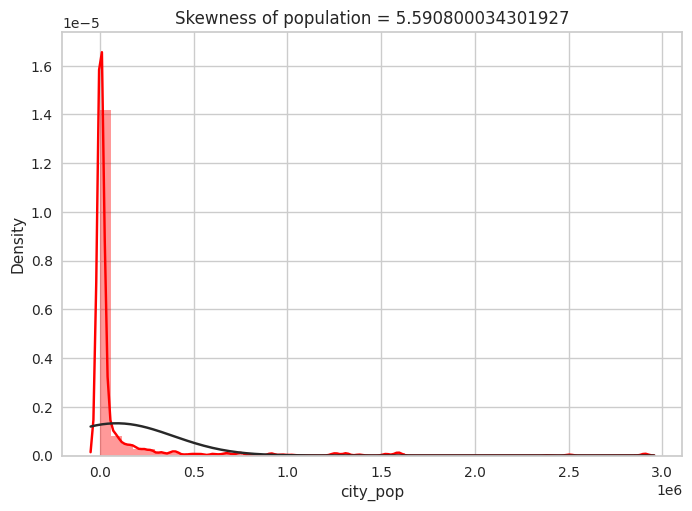

In [23]:
skewness = str(skew(total['city_pop']))
sns.distplot(total['city_pop'],fit = norm,color = 'red')
plt.title("Skewness of population"+" = "+skewness)
plt.show()

***3.1.4. Skewness of amount***

/tmp/ipykernel_127/3804404876.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total['amt'],fit = norm,color = 'green')


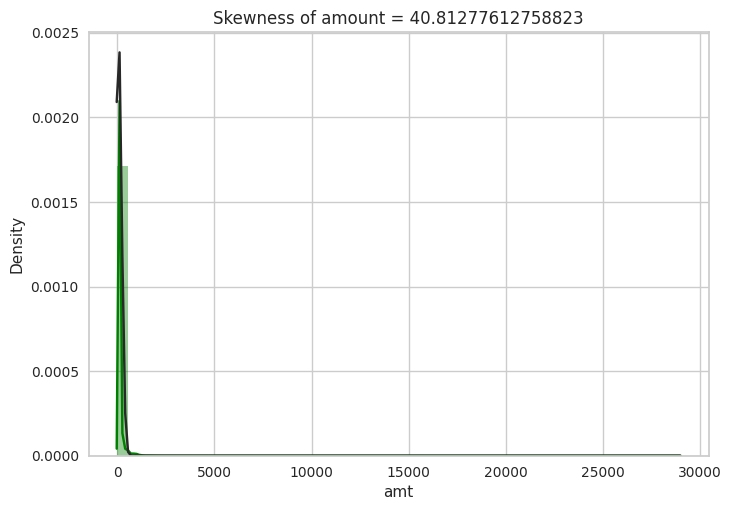

In [24]:
plt.rcParams.update({'font.size': 10})
skewness = str(skew(total['amt']))
sns.distplot(total['amt'],fit = norm,color = 'green')
plt.title("Skewness of amount"+" = "+skewness)
plt.show()

The majority of transactions fall within a narrow range, yet there is a notable presence of transactions involving substantial amounts, which raises suspicion of potential fraudulent activity.

***3.1.5. Distribution of is_fraud***

/tmp/ipykernel_127/3501631270.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(total['is_fraud'], fit=norm, color='blue')


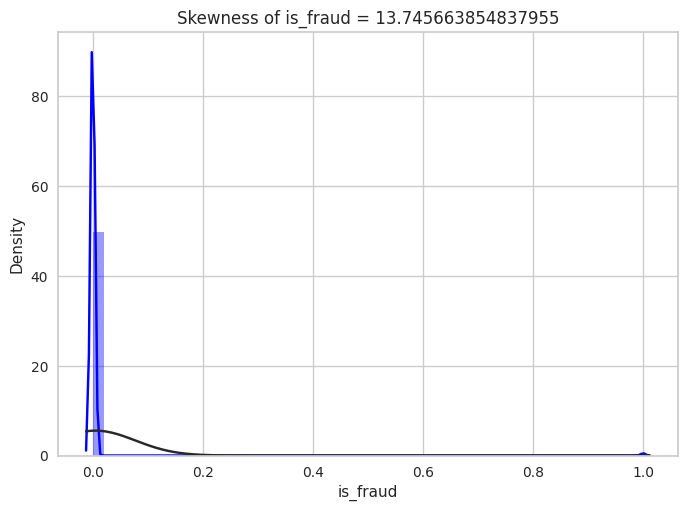

In [25]:
plt.rcParams.update({'font.size': 10})
skewness = str(skew(total['is_fraud']))
sns.distplot(total['is_fraud'], fit=norm, color='blue')
plt.title("Skewness of is_fraud" + " = " + skewness)
plt.show()

A lot of the data is highly skewed.

Also we can understand that proportion of non fraud transactions are much much larger than fraud transactions so we are looking at an imbalanced dataset.

***3.1.6. Remove numerical columns ????????????????????***

Certain numerical columns are not needed for modeling and so they can be removed:

In [26]:
total.drop(['cc_num','merchant','first','last','street','zip','trans_num','unix_time'],axis=1,inplace=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 object        
 4   city                   object        
 5   state                  object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   job                    object        
 10  dob                    datetime64[ns]
 11  merch_lat              float64       
 12  merch_long             float64       
 13  is_fraud               category      
 14  time                   datetime64[ns]
 15  hour_of_day            category      
dtypes: category(2), datetime64[ns](3), float64(5), int64(1), object(5)
memory usage: 215.5+ MB


***3.2. Categorical Variable Analysis***

In [27]:
total = pd.concat([df_test,df_train])
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              int6

In [28]:
total["is_fraud_category"]=total.is_fraud.apply(lambda x: "T" if x==1 else "F")
total["is_fraud_category"].astype("object")

0          F
1          F
2          F
3          F
4          F
          ..
1296670    F
1296671    F
1296672    F
1296673    F
1296674    F
Name: is_fraud_category, Length: 1852394, dtype: object

In [29]:
totalcategory = total.select_dtypes(include=['object'])

In [30]:
total[totalcategory.columns]

merchant        category        first  \
0                       fraud_Kirlin and Sons   personal_care         Jeff   
1                        fraud_Sporer-Keebler   personal_care       Joanne   
2        fraud_Swaniawski, Nitzsche and Welch  health_fitness       Ashley   
3                           fraud_Haley Group        misc_pos        Brian   
4                       fraud_Johnston-Casper          travel       Nathan   
...                                       ...             ...          ...   
1296670                     fraud_Reichel Inc   entertainment         Erik   
1296671              fraud_Abernathy and Sons     food_dining      Jeffrey   
1296672                  fraud_Stiedemann Ltd     food_dining  Christopher   
1296673   fraud_Reinger, Weissnat and Strosin     food_dining       Joseph   
1296674   fraud_Langosh, Wintheiser and Hyatt     food_dining      Jeffrey   

              last gender                         street  \
0          Elliott      M              351 Darlene Green   
1         Williams      F               3638 Marsh Union   
2            Lopez      F           9333 Valentine Point   
3         Williams      M    32941 Krystal Mill Apt. 552   
4           Massey      M       5783 Evan Roads Apt. 465   
...            ...    ...                            ...   
1296670  Patterson      M       162 Jessica Row Apt. 072   
1296671      White      M  8617 Holmes Terrace Suite 651   
1296672  Castaneda      M     1632 Cohen Drive Suite 639   
1296673     Murray      M           42933 Ryan Underpass   
1296674      Smith      M           135 Joseph Mountains   

                             city state                               job  \
0                        Columbia    SC               Mechanical engineer   
1                         Altonah    UT            Sales professional, IT   
2                        Bellmore    NY                 Librarian, public   
3                      Titusville    FL                      Set designer   
4                        Falmouth    MI                Furniture designer   
...                           ...   ...                               ...   
1296670                     Hatch    UT                      Geoscientist   
1296671                 Tuscarora    MD  Production assistant, television   
1296672  High Rolls Mountain Park    NM                   Naval architect   
1296673                 Manderson    SD             Volunteer coordinator   
1296674                      Sula    MT          Therapist, horticultural   

                                trans_num  
0        2da90c7d74bd46a0caf3777415b3ebd3  
1        324cc204407e99f51b0d6ca0055005e7  
2        c81755dbbbea9d5c77f094348a7579be  
3        2159175b9efe66dc301f149d3d5abf8c  
4        57ff021bd3f328f8738bb535c302a31b  
...                                   ...  
1296670  440b587732da4dc1a6395aba5fb41669  
1296671  278000d2e0d2277d1de2f890067dcc0a  
1296672  483f52fe67fabef353d552c1e662974c  
1296673  d667cdcbadaaed3da3f4020e83591c83  
1296674  8f7c8e4ab7f25875d753b422917c98c9  

[1852394 rows x 10 columns]

***3.2.1. Number of Credit Card Frauds by Job***

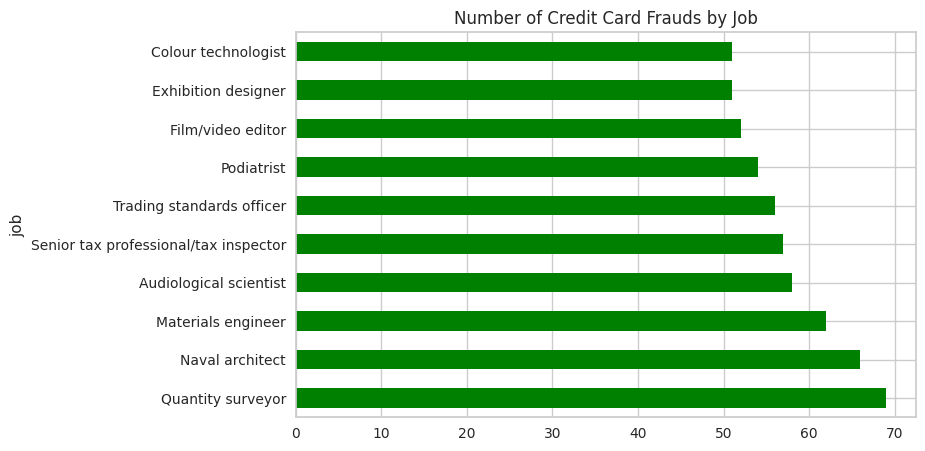

In [31]:
total[total['is_fraud_category'] == "T"]["job"].value_counts(sort=True, ascending=False).head(10).plot(kind="barh", color='green', figsize=(8, 5))
plt.title("Number of Credit Card Frauds by Job")
plt.show()

Most frauds occured in jobs of quantity surveyor followed by naval architect and materials engineer.

***3.2.2. Number of Credit Card Frauds by City***

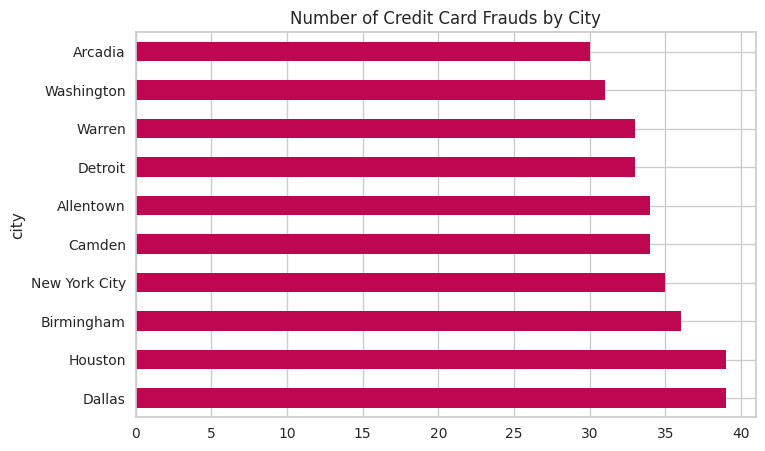

In [32]:
import random

def randomcolor():
    r = random.random()
    b = random.random()
    g = random.random()
    rgb = [r, g, b]
    return rgb

plt.rcParams.update({'font.size': 14})  # Adjust font size

# Assuming 'randomcolor' function is defined
total[total['is_fraud_category'] == "T"]["city"].value_counts(sort=True, ascending=False).head(10).plot(kind="barh", color=randomcolor(), figsize=(8, 5))
plt.title("Number of Credit Card Frauds by City")
plt.show()


***3.2.3. Number of Credit Card Frauds by Category***

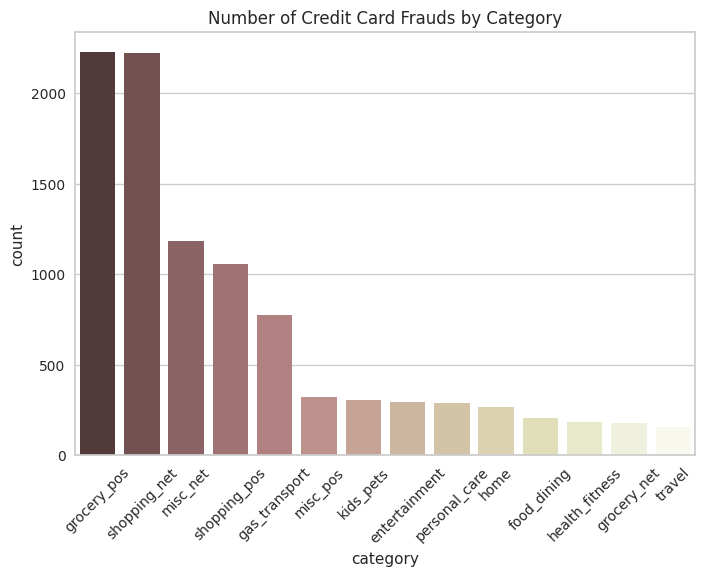

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=total[total['is_fraud_category'] == "T"], x='category', order=total[total['is_fraud_category'] == "T"]['category'].value_counts().index, palette='pink')
plt.xticks(rotation=45)
plt.title("Number of Credit Card Frauds by Category")
plt.show()

Most frauds happened in categories of shopping_net, grocery_pos and misc_net.

***3.2.4. Number of Credit Card Frauds by Gender***

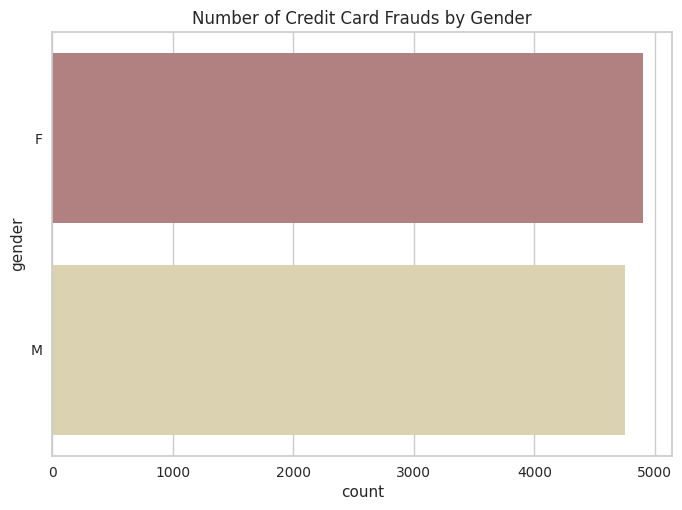

In [34]:
sns.countplot(data=total[total['is_fraud_category'] == "T"], y='gender', order=total[total['is_fraud_category'] == "T"]['gender'].value_counts().index, palette='pink')
plt.title("Number of Credit Card Frauds by Gender")
plt.show()

Most cases of fraud occured with female customers, but the number is almost the same for both Males and Females.

***3.2.5. Summarize using pandas_profiling***

In [35]:
groups = [pd.Grouper(key="trans_date_trans_time", freq="1W"), "is_fraud"]
df_ = total.groupby(by=groups).agg({"amt":'mean',"trans_num":"count"}).reset_index()

In [36]:
def add_traces(df, x, y,hue, mode, cmap, showlegend=None):
    name_map = {1:"Yes", 0:"No"}
    traces = []
    for flag in df[hue].unique():
        traces.append(
            go.Scatter(
                x=df[df[hue]==flag][x],
                y=df[df[hue]==flag][y],
                mode=mode,
                marker=dict(color=cmap[flag]),
                showlegend=showlegend,
                name=name_map[flag]
            )
        )
    return traces

In [37]:
df_ = total.groupby(by=[pd.Grouper(key="trans_date_trans_time", freq="1W"),
                           'is_fraud','category']).agg({"amt":'mean',"trans_num":"count"}).reset_index()

fig = px.scatter(df_,
        x='trans_date_trans_time',
        y='amt',
        color='is_fraud',
        facet_col ='category',
        facet_col_wrap=3,
        facet_col_spacing=.04,
        color_discrete_map={0:'#3498db', 1:'#e67e22'}
)

fig.update_layout(height=1400,
                  width=960,
                  legend=dict(title='Is fraud?'),
                  plot_bgcolor='#fafafa'
                 )

fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))
fig.for_each_xaxis(lambda xaxis: xaxis.update(showticklabels=True, title=''))

fig.show();

In [38]:
import plotly.express as px

df_ = total[df_train.is_fraud == 1].groupby(by='hour_of_day').agg({'trans_num': 'count'}).reset_index()

fig = px.bar(data_frame=df_,
             y='hour_of_day',
             x='trans_num',
             labels={'trans_num': 'Number of transactions'},
             orientation='h',
             color_discrete_sequence=['#1f77b4'] * len(df_)
            )

fig.update_layout(
    title=dict(
        text='Number of fraud transactions by hours of day',
        x=0.5
    ),
    plot_bgcolor='#fafafa',
    yaxis=dict(
        tickmode='linear',  # Show all ticks
        dtick=1  # Set the tick interval to 1
    )
)

fig.show()

/tmp/ipykernel_127/2923811168.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [39]:
df_ = df_train.groupby(by=[pd.Grouper(key="trans_date_trans_time", freq="1M"),
                           'is_fraud','category']).agg({"amt":'sum',"trans_num":"count"}).reset_index()

# Choose color palette
color_palette = px.colors.qualitative.Set2

fig = px.area(
    df_[df_.is_fraud == 1],
    x='trans_date_trans_time',
    y='amt',
    color='category',
    color_discrete_sequence=color_palette
)

fig.update_layout(height=600,
                  width=960,
                  legend=dict(title='Categories'),
                  plot_bgcolor='#fafafa',
                  title='Monthly Sum of Amount for Fraudulent Transactions by Category'
                 )

fig.show();

***3.3 Distribution of is_fraud in total data***

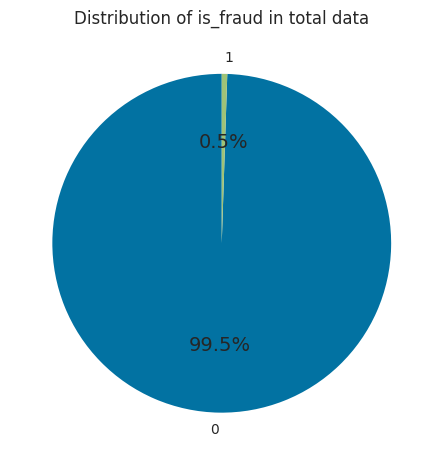

is_fraud
0    1842743
1       9651
Name: count, dtype: int64


In [40]:
value_counts = total['is_fraud'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of is_fraud in total data')
plt.show()
print(value_counts)

It seems that our dataset is imbalanced. Because only around 10,000 entries represent fraud transactions out of nearly 1.8 million entries.

***3.4 creating transacation month and transaction year columns(feature engineering)***

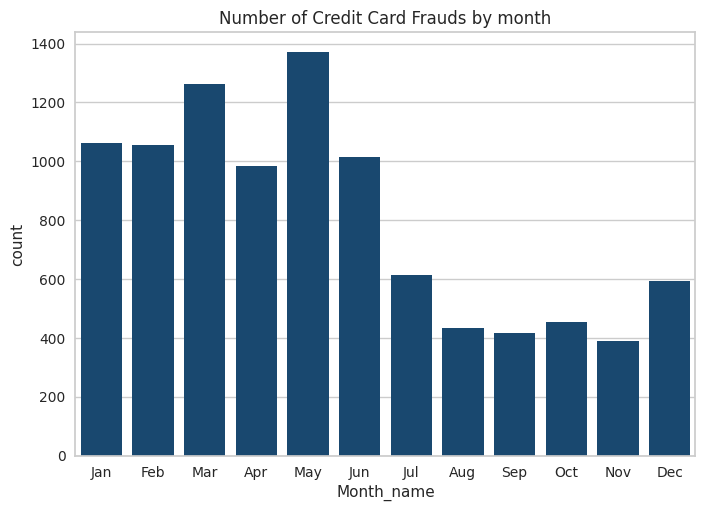

In [41]:
import calendar

total['trans_month'] = pd.DatetimeIndex(total['trans_date_trans_time']).month
total['trans_year'] = pd.DatetimeIndex(total['trans_date_trans_time']).year

total['Month_name'] = total['trans_month'].apply(lambda x: calendar.month_abbr[x])

# Filter rows where 'is_fraud' is 1
fraud_data = total[total["is_fraud"] == 1]

# Reset the index
fraud_data.reset_index(drop=True, inplace=True)

# Plot countplot
sns.countplot(data=fraud_data, x='Month_name', color=randomcolor())
plt.title("Number of Credit Card Frauds by month")
plt.show()

# Drop the 'Month_name' column
total.drop('Month_name', axis=1, inplace=True)


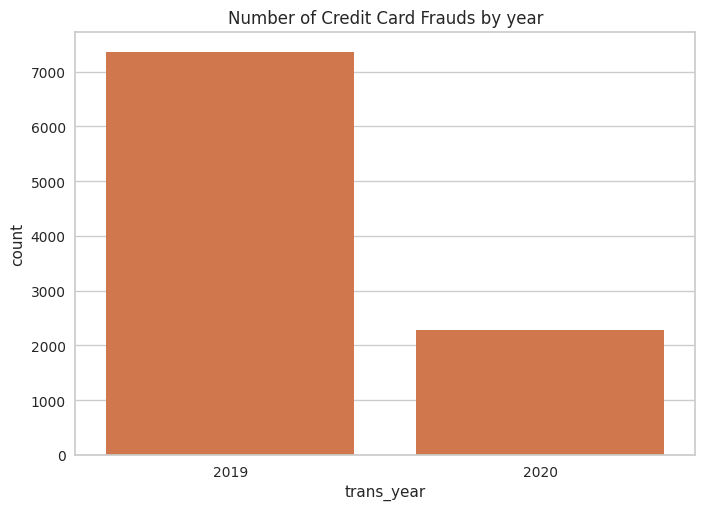

In [42]:
sns.countplot(data=total[total["is_fraud"]==1].reset_index(drop=True), x='trans_year', color=randomcolor())
plt.title("Number of Credit Card Frauds by year")
plt.show()

***3.5 creating age variable(feature engineering)***

In [43]:
total["trans_date_trans_time"] = pd.to_datetime(total["trans_date_trans_time"], infer_datetime_format=True)
total["dob"] = pd.to_datetime(total["dob"], infer_datetime_format=True)

# Calculate the age in years
total["age"] = (total["trans_date_trans_time"] - total["dob"]).dt.days // 365
total["age"].head()

/tmp/ipykernel_127/643621746.py:1: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/tmp/ipykernel_127/643621746.py:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



0    30
1    40
2    56
3    52
4    32
Name: age, dtype: int64

In [44]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 28 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              int6

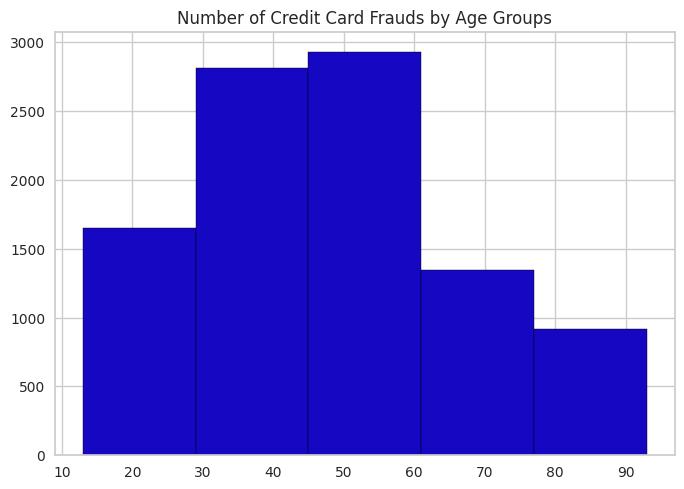

In [45]:
fraud=total[total["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.age, edgecolor = "black", bins = 5, color=randomcolor())
plt.title("Number of Credit Card Frauds by Age Groups")
plt.show()

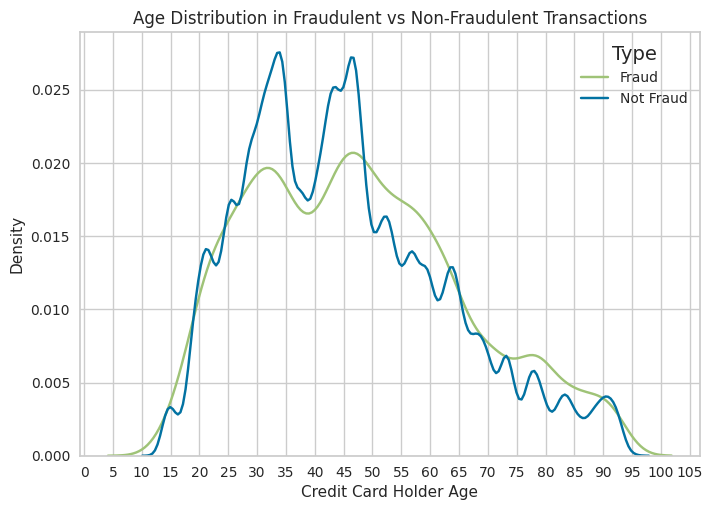

In [46]:
#age vs fraud
#import datetime as dt
#df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
ax=sns.kdeplot(x='age',data=total, hue='is_fraud', common_norm=False)
ax.set_xlabel('Credit Card Holder Age')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,5))
plt.title('Age Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

The age distribution is visibly different between 2 transaction types. In normal transactions, there are 2 peaks at the age of 37-38 and 49-50, while in fraudulent transactions, the age distribution is a little smoother and the second peak does include a wider age group from 50-65. This does suggest that older people are potentially more prone to fraud.

***3.6 Finding distance***

Finding distance from customer location to merchant location in degrees latitude and degrees longitude

In [47]:
# latitudinal_distance
total['lat_distance'] = abs(round(total['merch_lat']-total['lat'],3))
total['long_distance'] = abs(round(total['merch_long']-total['long'],3))

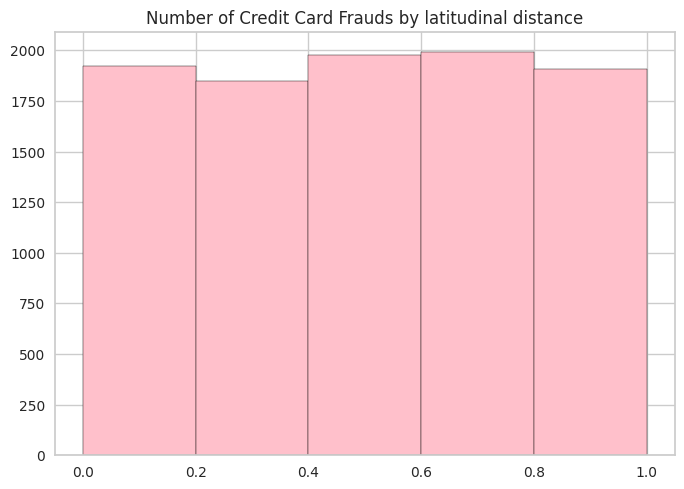

In [48]:
fraud = total[total["is_fraud"]==1]
fig, ax = plt.subplots()
ax.hist(fraud.lat_distance, edgecolor = "black", bins = 5, color='pink')
plt.title("Number of Credit Card Frauds by latitudinal distance")
plt.show()

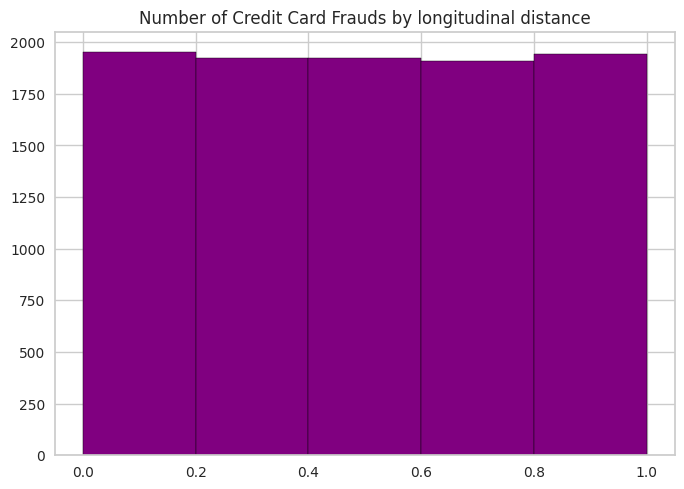

In [49]:
fig, ax = plt.subplots()
ax.hist(fraud.long_distance, edgecolor = "black", bins = 5, color='purple')
plt.title("Number of Credit Card Frauds by longitudinal distance")
plt.show()

In [50]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 30 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 object        
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              int6

***3.7 gender values to binary values***

In [51]:
total.gender.value_counts()

gender
F    1014749
M     837645
Name: count, dtype: int64

In [52]:
total.gender=total.gender.apply(lambda x: 1 if x=="M" else 0)
total.gender.value_counts()

gender
0    1014749
1     837645
Name: count, dtype: int64

***3.8 Weekly Trend***

/tmp/ipykernel_127/4208982524.py:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



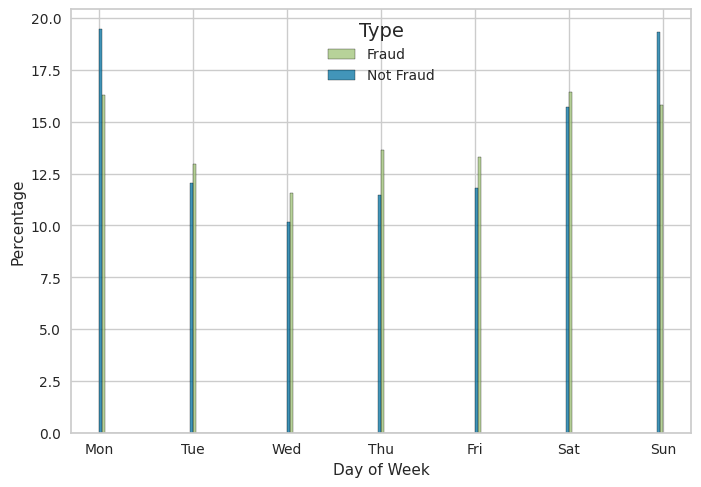

In [53]:
#day of week vs fraud
total['day']=pd.to_datetime(total['trans_date_trans_time']).dt.dayofweek
ax=sns.histplot(data=total, x="day", hue="is_fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day of Week')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

In [54]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 31 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   first                  object        
 6   last                   object        
 7   gender                 int64         
 8   street                 object        
 9   city                   object        
 10  state                  object        
 11  zip                    int64         
 12  lat                    float64       
 13  long                   float64       
 14  city_pop               int64         
 15  job                    object        
 16  dob                    datetime64[ns]
 17  trans_num              object        
 18  unix_time              int6

# 4. Model Building

In [55]:
from sklearn.model_selection import train_test_split

***Dropping some variables ?????????????***

We drop some variables which are not useful for model building.

In [56]:
drop_cols = ['cc_num','merchant','first','last','street','zip','trans_num','unix_time','time','is_fraud_category', 'trans_date_trans_time','city','lat','long','job','dob','merch_lat','merch_long','state']
total=total.drop(drop_cols,axis=1)
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   category       object  
 1   amt            float64 
 2   gender         int64   
 3   city_pop       int64   
 4   is_fraud       category
 5   hour_of_day    category
 6   trans_month    int32   
 7   trans_year     int32   
 8   age            int64   
 9   lat_distance   float64 
 10  long_distance  float64 
 11  day            int32   
dtypes: category(2), float64(3), int32(3), int64(3), object(1)
memory usage: 137.8+ MB


In [57]:
total = pd.get_dummies(total,columns=['category'],drop_first=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852394 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   amt                      float64 
 1   gender                   int64   
 2   city_pop                 int64   
 3   is_fraud                 category
 4   hour_of_day              category
 5   trans_month              int32   
 6   trans_year               int32   
 7   age                      int64   
 8   lat_distance             float64 
 9   long_distance            float64 
 10  day                      int32   
 11  category_food_dining     bool    
 12  category_gas_transport   bool    
 13  category_grocery_net     bool    
 14  category_grocery_pos     bool    
 15  category_health_fitness  bool    
 16  category_home            bool    
 17  category_kids_pets       bool    
 18  category_misc_net        bool    
 19  category_misc_pos        bool    
 20  category_personal_care   bool

# split, handle imbalanced data, run model

***spilit to train and test***

According to our data that is imbalanced, we should decide about when we should do oversampling or undersampling.

Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

So, at the first we spilit our dataset to test and train and then we decide about oversampling/undersampling techniques for different models. 

In [58]:
Y=total['is_fraud'].values
X=total.drop("is_fraud", axis='columns').values

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.2, random_state=42)

In this case, 20% of the data will be used for testing, and the remaining 80% will be used for training.

***Oversampling Models***

***1. Logistic Regression Classifier:***
Logistic regression may benefit from oversampling, especially when dealing with imbalanced datasets. It helps to balance the class distribution and improve the model's ability to predict the minority class.

In [60]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# We have already split data into X_train, X_test, Y_train, Y_test

# Step 1: Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Step 2: Fit and apply oversampling to the training set
X_train_resampled_log, Y_train_resampled_log = oversampler.fit_resample(X_train, Y_train)

# Step 3: Initialize and train the Logistic Regression Classifier on the resampled data
logreg_classifier = LogisticRegression(random_state=42)
logreg_classifier.fit(X_train_resampled_log, Y_train_resampled_log)

# Step 4: Make predictions on the test set
Y_pred = logreg_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))


Accuracy: 0.9524534454044629

Confusion Matrix:
 [[351453  17129]
 [   486   1411]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    368582
           1       0.08      0.74      0.14      1897

    accuracy                           0.95    370479
   macro avg       0.54      0.85      0.56    370479
weighted avg       0.99      0.95      0.97    370479



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = logreg_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')

plt.title('AUC Curve')
plt.legend(loc='lower right')
plt.show()

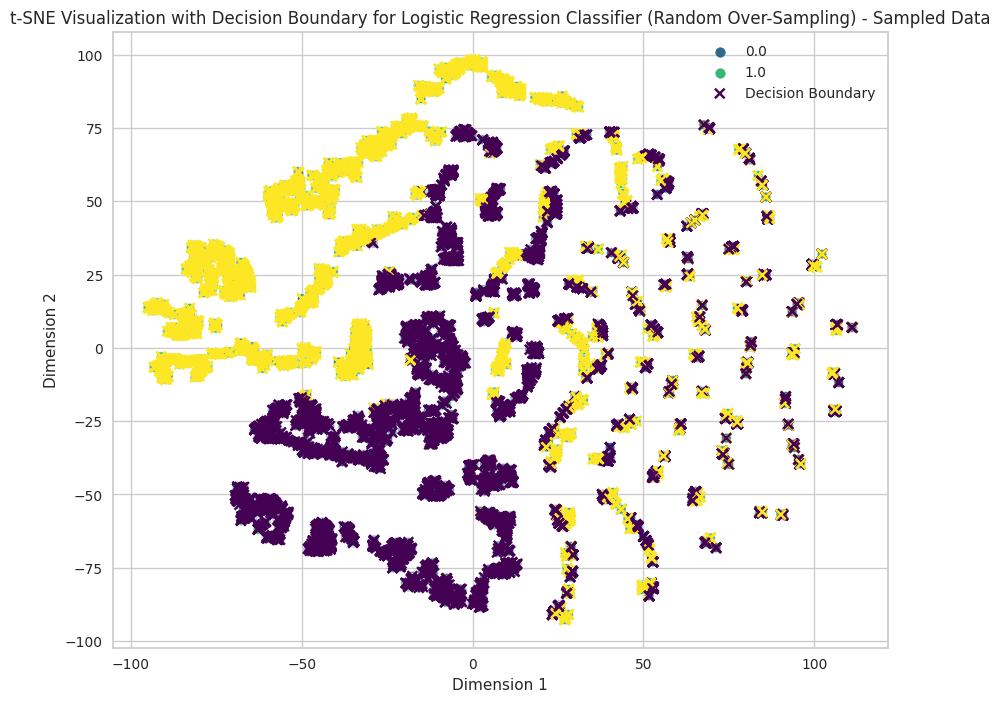

In [61]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_train_resampled_log.shape[0], size=sample_size_tsne, replace=False)

X_train_resampled_log_sampled = X_train_resampled_log[sample_indices_tsne]
Y_train_resampled_log_sampled = Y_train_resampled_log[sample_indices_tsne]

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = logreg_classifier.predict_proba(X_test)[:, 1]

# Step 7: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_resampled_log_sampled)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_train_resampled_log_sampled)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)

# Get decision boundary from the classifier
decision_boundary = logreg_classifier.predict(X_train_resampled_log_sampled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=decision_boundary, cmap='viridis', marker='x', label='Decision Boundary')

plt.title('t-SNE Visualization with Decision Boundary for Logistic Regression Classifier (Random Over-Sampling) - Sampled Data')
plt.legend()
plt.show()

***2. Support Vector Machine (SVM) Classifier:*** SVMs can benefit from oversampling, particularly when the dataset is imbalanced. Oversampling can improve the decision boundary, especially when the positive class is underrepresented.

Accuracy: 0.819

Confusion Matrix:
 [[8183 1777]
 [  33    7]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90      9960
           1       0.00      0.17      0.01        40

    accuracy                           0.82     10000
   macro avg       0.50      0.50      0.45     10000
weighted avg       0.99      0.82      0.90     10000



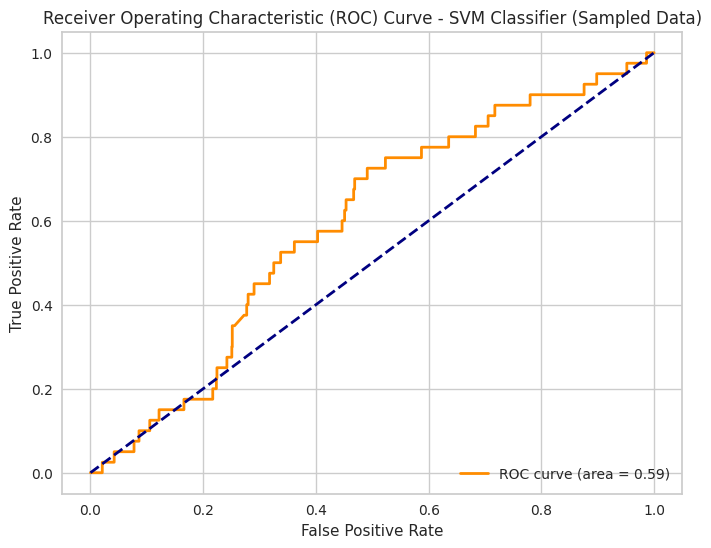

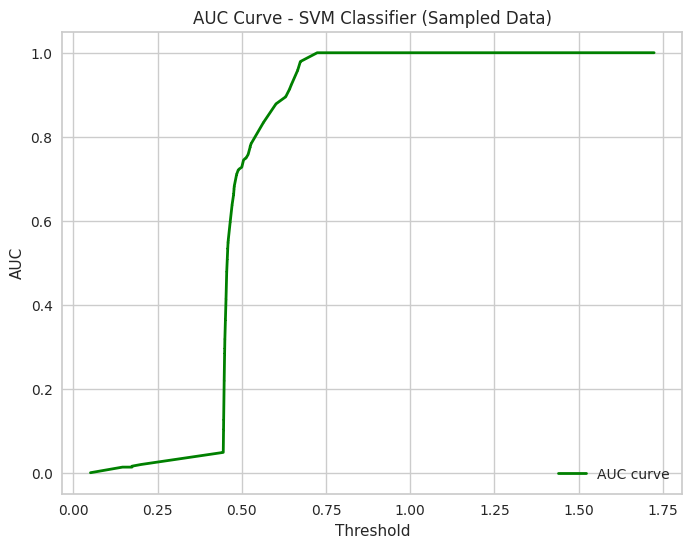

In [63]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Sample 10,000 data points for training and testing
sample_size = 10000
sample_indices = np.random.choice(X_train.shape[0], size=sample_size, replace=False)

X_train_sample = X_train[sample_indices, :]
Y_train_sample = Y_train[sample_indices]

sample_indices_test = np.random.choice(X_test.shape[0], size=sample_size, replace=False)

X_test_sample = X_test[sample_indices_test, :]
Y_test_sample = Y_test[sample_indices_test]

# Step 1: Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Step 2: Fit and apply oversampling to the training set
X_train_resampled_svm, Y_train_resampled_svm = oversampler.fit_resample(X_train_sample, Y_train_sample)

# Step 3: Initialize and train the SVM Classifier on the resampled data
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train_resampled_svm, Y_train_resampled_svm)

# Step 4: Make predictions on the test set
Y_pred = svm_classifier.predict(X_test_sample)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test_sample, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test_sample, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test_sample, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = svm_classifier.predict_proba(X_test_sample)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_sample, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM Classifier (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - SVM Classifier (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

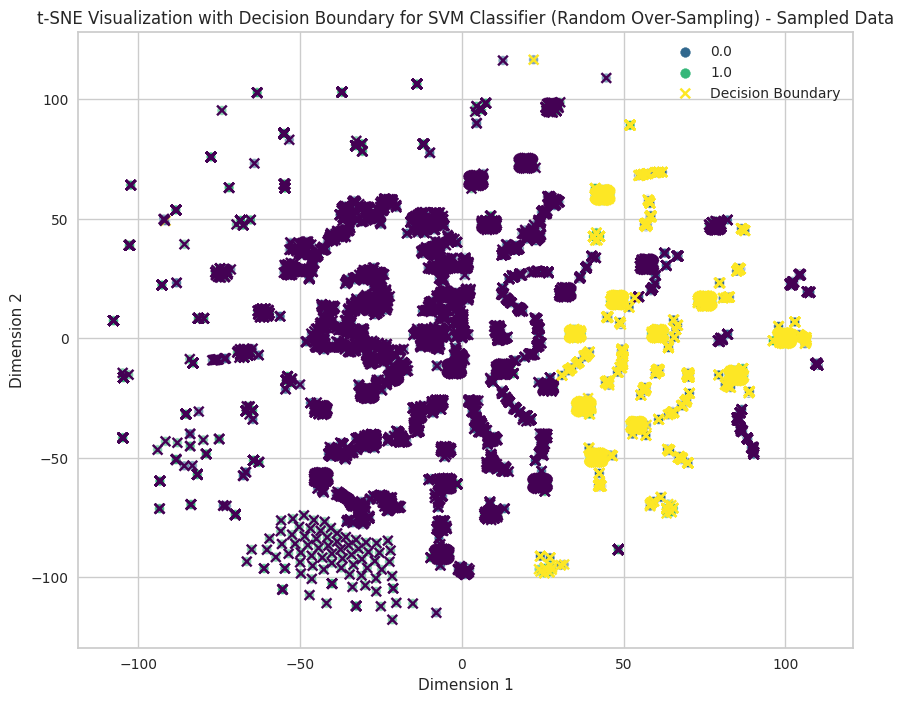

In [64]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_train_resampled_svm.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_train_resampled_svm[sample_indices, :]
Y_tsne_sample = Y_train_resampled_svm[sample_indices]

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Step 7: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)

# Get decision boundary from the classifier
decision_boundary = svm_classifier.predict(X_tsne_sample)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=decision_boundary, cmap='viridis', marker='x', label='Decision Boundary')

plt.title('t-SNE Visualization with Decision Boundary for SVM Classifier (Random Over-Sampling) - Sampled Data')
plt.legend()
plt.show()

***3. K-nearest neighbor (KNN) Classifier:*** KNN can benefit from oversampling, especially if the class distribution is highly imbalanced. It helps prevent the model from being biased toward the majority class.

Accuracy: 0.9524534454044629

Confusion Matrix:
 [[351453  17129]
 [   486   1411]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    368582
           1       0.08      0.74      0.14      1897

    accuracy                           0.95    370479
   macro avg       0.54      0.85      0.56    370479
weighted avg       0.99      0.95      0.97    370479



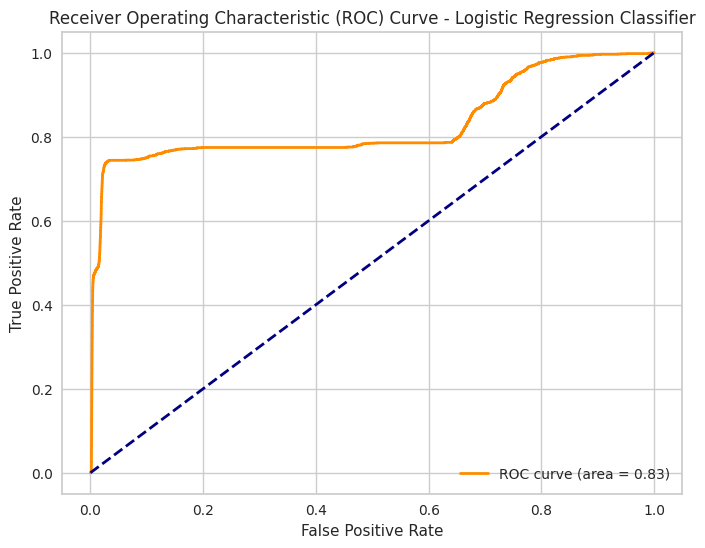

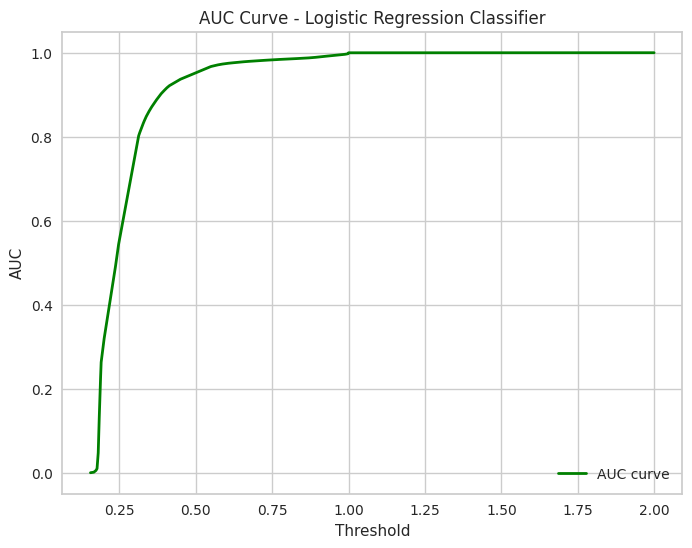

In [67]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Initialize the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Step 2: Fit and apply oversampling to the training set
X_train_resampled_knn, Y_train_resampled_knn = oversampler.fit_resample(X_train, Y_train)

# Step 3: Initialize and train the Logistic Regression Classifier on the resampled data
logreg_classifier = LogisticRegression(random_state=42)
logreg_classifier.fit(X_train_resampled_knn, Y_train_resampled_log)

# Step 4: Make predictions on the test set
Y_pred = logreg_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = logreg_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Logistic Regression Classifier')
plt.legend(loc='lower right')
plt.show()

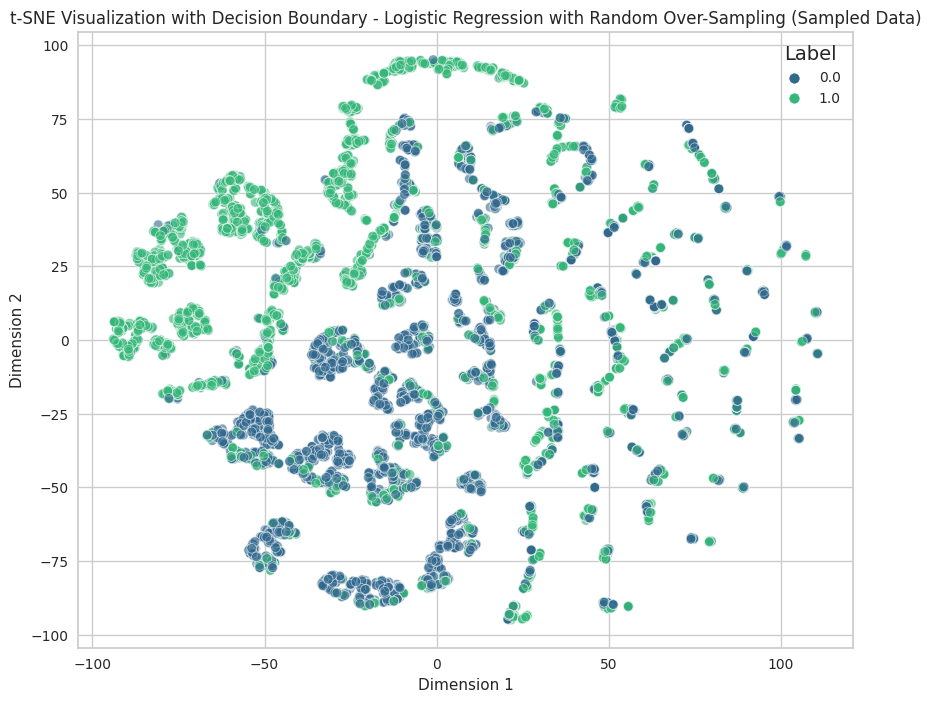

In [68]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_train_resampled_knn.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_train_resampled_knn[sample_indices, :]
Y_tsne_sample = Y_train_resampled_knn[sample_indices]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Logistic Regression with Random Over-Sampling (Sampled Data)')
plt.show()

***undersampling Models***

***1. Decision Tree Classifier:*** Decision trees are less sensitive to imbalanced datasets compared to some other algorithms. However, if there is a significant class imbalance, undersampling the majority class may help.

Accuracy: 0.9684327586718815

Confusion Matrix:
 [[356951  11631]
 [    64   1833]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98    368582
           1       0.14      0.97      0.24      1897

    accuracy                           0.97    370479
   macro avg       0.57      0.97      0.61    370479
weighted avg       1.00      0.97      0.98    370479



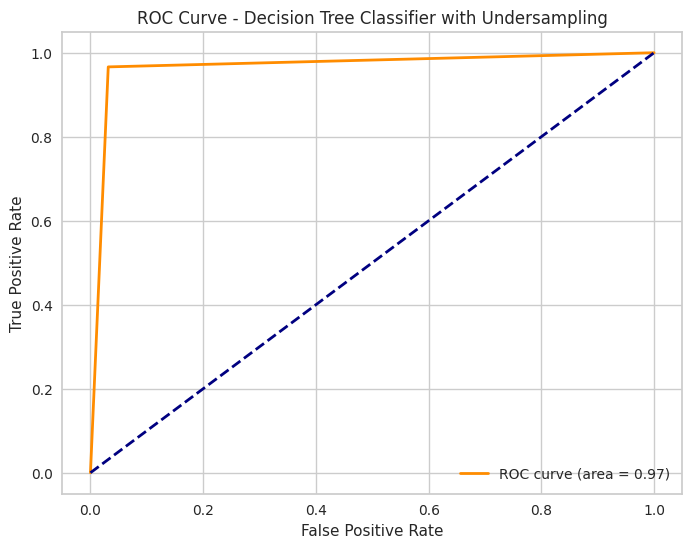

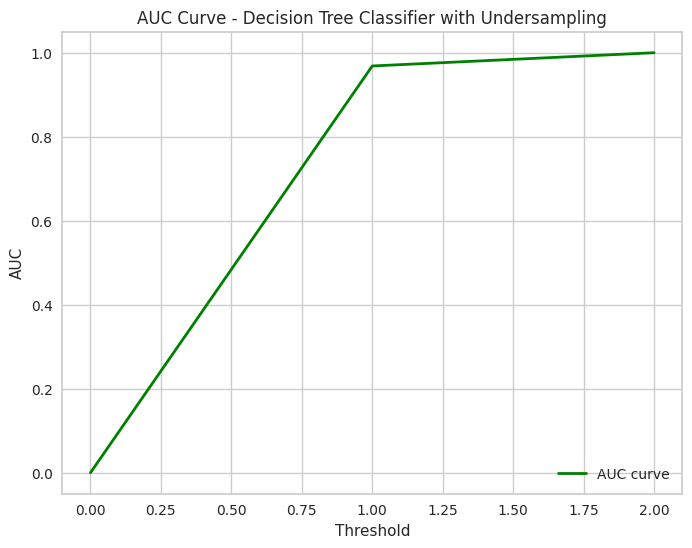

In [70]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Step 2: Fit and apply undersampling to the training set
X_train_resampled_dt, Y_train_resampled_dt = undersampler.fit_resample(X_train, Y_train)

# Step 3: Initialize and train the Decision Tree Classifier on the resampled data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_resampled_dt, Y_train_resampled_dt)

# Step 4: Make predictions on the test set
Y_pred = dt_classifier.predict(X_test)

# Step 5 Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Classifier with Undersampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Decision Tree Classifier with Undersampling')
plt.legend(loc='lower right')
plt.show()


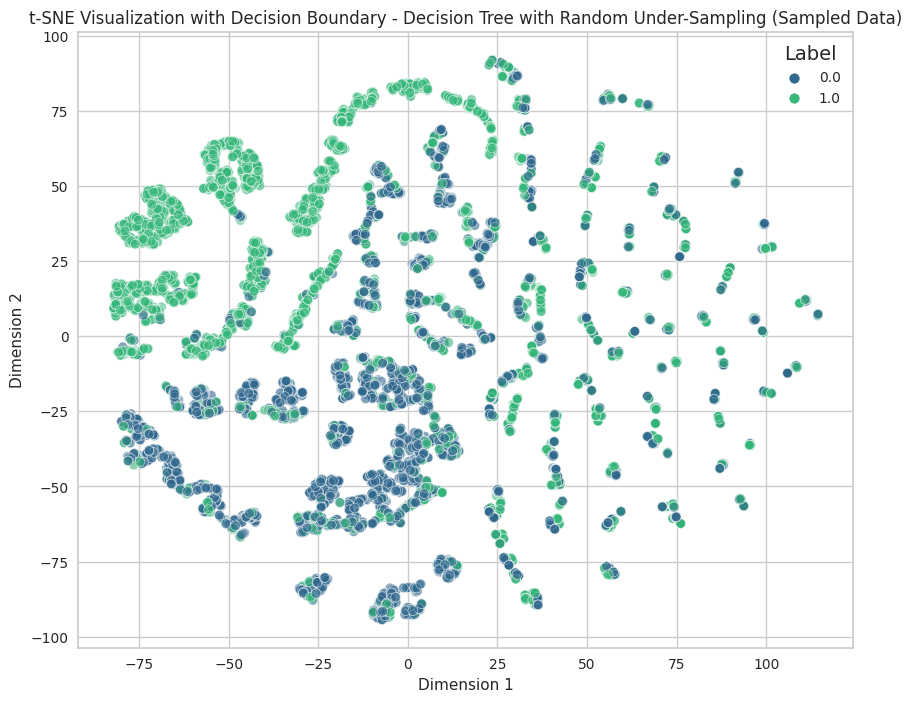

In [71]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_train_resampled_dt.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_train_resampled_dt[sample_indices, :]
Y_tsne_sample = Y_train_resampled_dt[sample_indices]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Decision Tree with Random Under-Sampling (Sampled Data)')
plt.show()

***2. Random Forest Classifier:*** Random Forests are generally robust to imbalanced datasets, but undersampling the majority class might be considered, depending on the nature of the problem.

Accuracy: 0.9775506843842701

Confusion Matrix:
 [[360335   8247]
 [    70   1827]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    368582
           1       0.18      0.96      0.31      1897

    accuracy                           0.98    370479
   macro avg       0.59      0.97      0.65    370479
weighted avg       1.00      0.98      0.99    370479



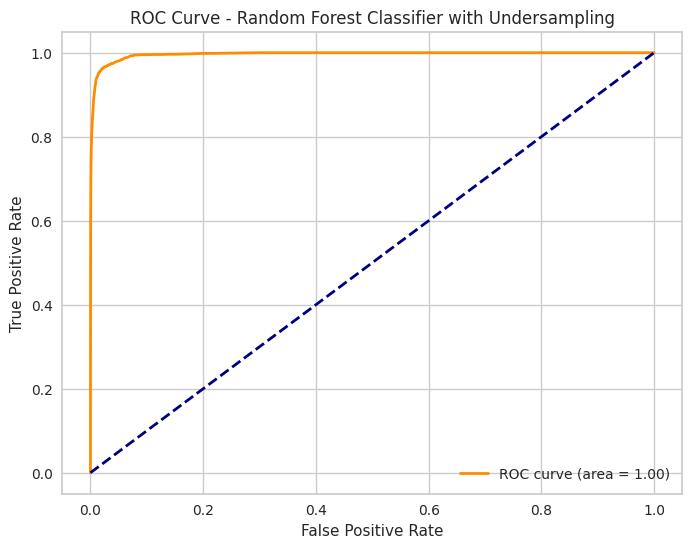

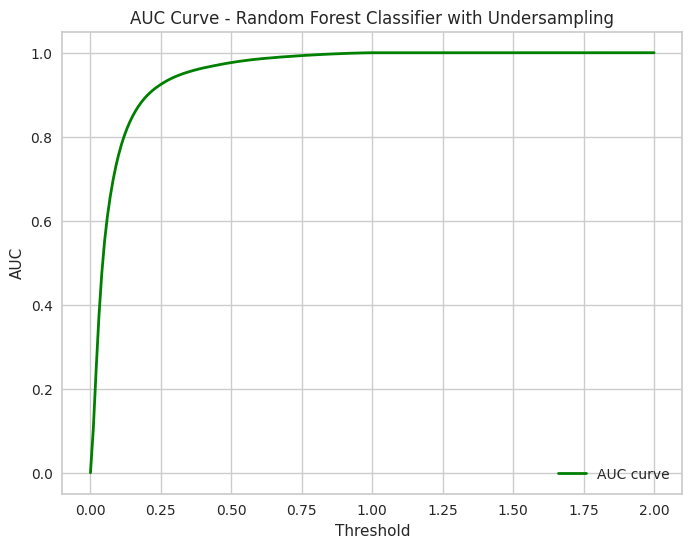

In [73]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Step 2: Fit and apply undersampling to the training set
X_train_resampled_rf, Y_train_resampled_rf = undersampler.fit_resample(X_train, Y_train)

# Step 3: Initialize and train the Random Forest Classifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled_rf, Y_train_resampled_rf)

# Step 4: Make predictions on the test set
Y_pred = rf_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier with Undersampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Random Forest Classifier with Undersampling')
plt.legend(loc='lower right')
plt.show()


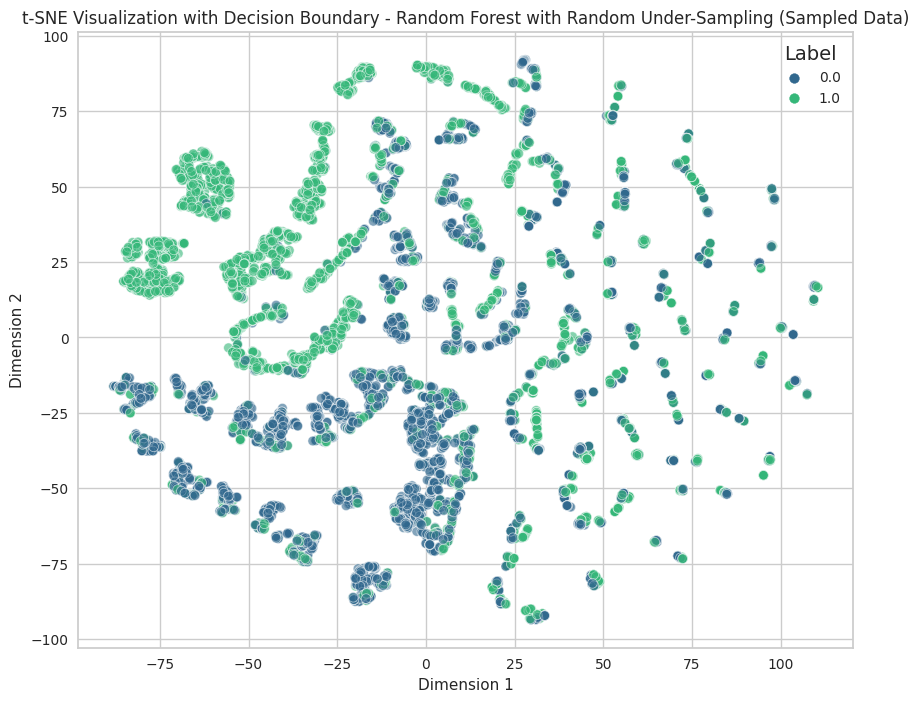

In [74]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_train_resampled_rf.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_train_resampled_rf[sample_indices, :]
Y_tsne_sample = Y_train_resampled_rf[sample_indices]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Random Forest with Random Under-Sampling (Sampled Data)')
plt.show()

***3. Naive Bayes:*** Naive Bayes can work well with imbalanced datasets, and oversampling/undersampling might not be necessary. However, undersampling the majority class can be tried if the imbalance is severe.

Accuracy: 0.9750431198529471

Confusion Matrix:
 [[359854   8728]
 [   518   1379]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    368582
           1       0.14      0.73      0.23      1897

    accuracy                           0.98    370479
   macro avg       0.57      0.85      0.61    370479
weighted avg       0.99      0.98      0.98    370479



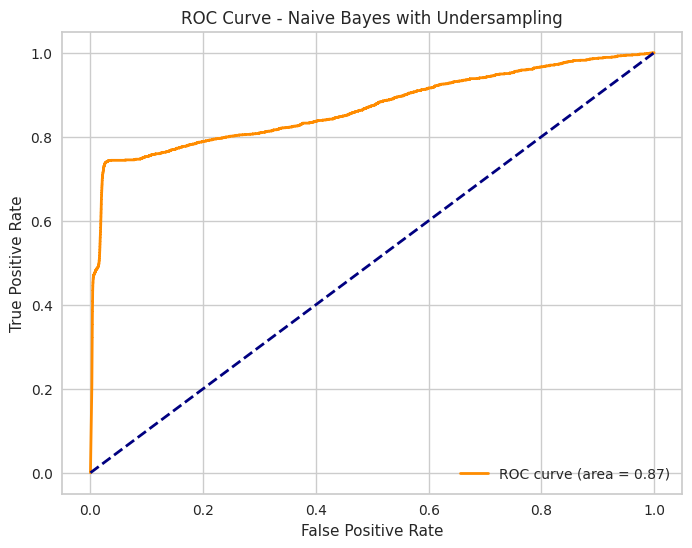

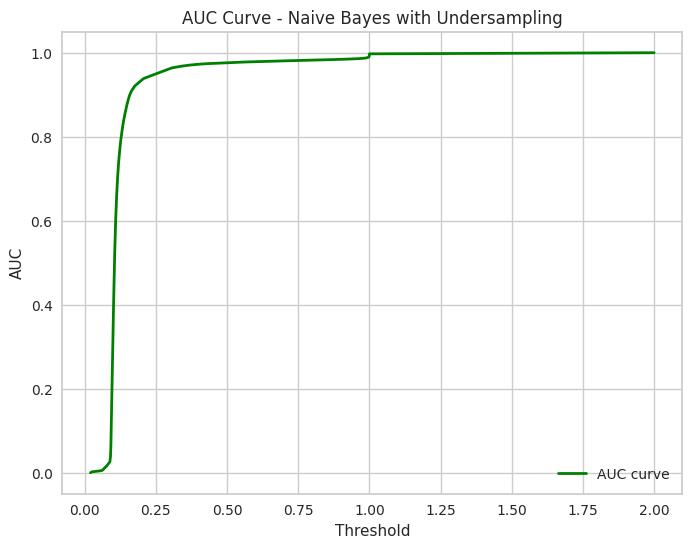

In [76]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Initialize the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)

# Step 2: Fit and apply undersampling to the training set
X_train_resampled_nb, Y_train_resampled_nb = undersampler.fit_resample(X_train, Y_train)

# Step 3: Initialize and train the Naive Bayes classifier on the resampled data
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_resampled_nb, Y_train_resampled_nb)

# Step 4: Make predictions on the test set
Y_pred = nb_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes with Undersampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Naive Bayes with Undersampling')
plt.legend(loc='lower right')
plt.show()


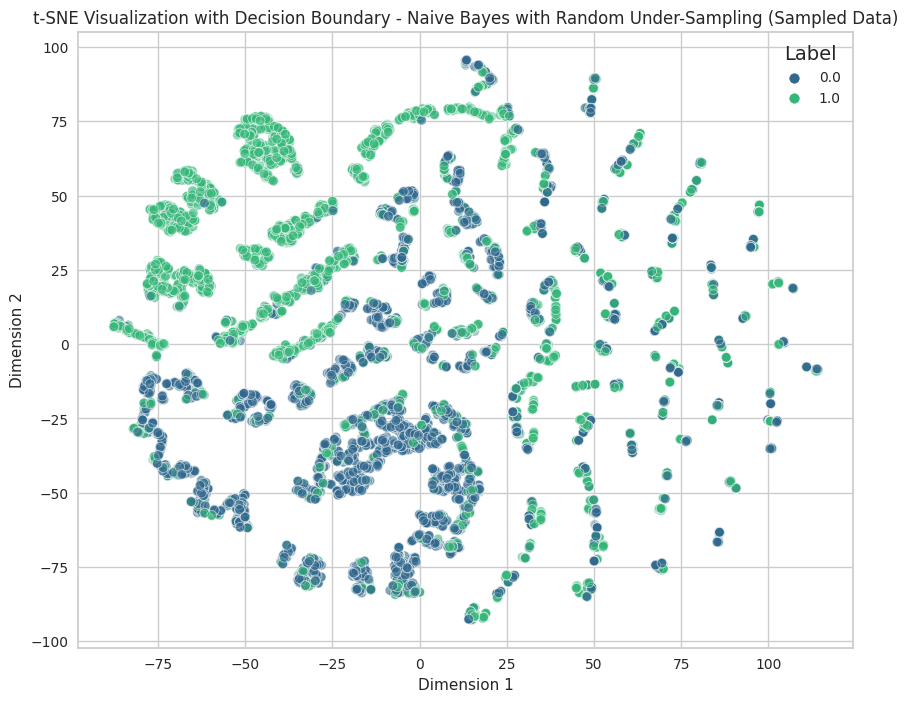

In [77]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_train_resampled_nb.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_train_resampled_nb[sample_indices, :]
Y_tsne_sample = Y_train_resampled_nb[sample_indices]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Naive Bayes with Random Under-Sampling (Sampled Data)')
plt.show()

# handling imbalance, split, run model

***oversampling models***

***1. Logistic Regression Classifier***

Accuracy: 0.855939101720531

Confusion Matrix:
 [[351316  17233]
 [ 88954 279595]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87    368549
           1       0.94      0.76      0.84    368549

    accuracy                           0.86    737098
   macro avg       0.87      0.86      0.85    737098
weighted avg       0.87      0.86      0.85    737098



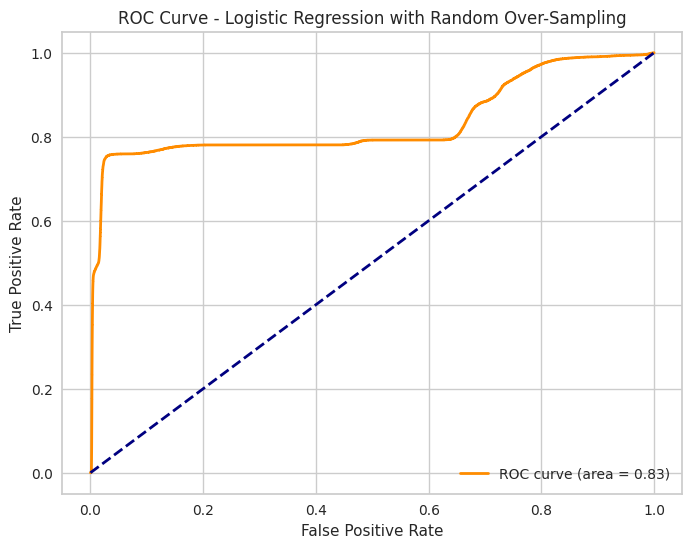

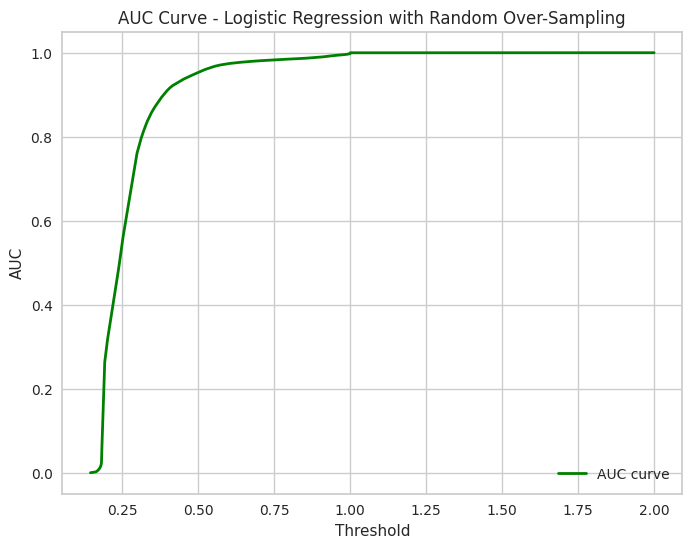

In [79]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Handle imbalanced data using Random Over-Sampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, Y_resampled = oversampler.fit_resample(total.drop('is_fraud', axis=1), total['is_fraud'])

# Step 2: Split the resampled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled)

# Step 3: Initialize and train the Logistic Regression classifier on the resampled data
logreg_classifier = LogisticRegression(random_state=42)
logreg_classifier.fit(X_train, Y_train)

# Step 4: Make predictions on the test set
Y_pred = logreg_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = logreg_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression with Random Over-Sampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Logistic Regression with Random Over-Sampling')
plt.legend(loc='lower right')
plt.show()

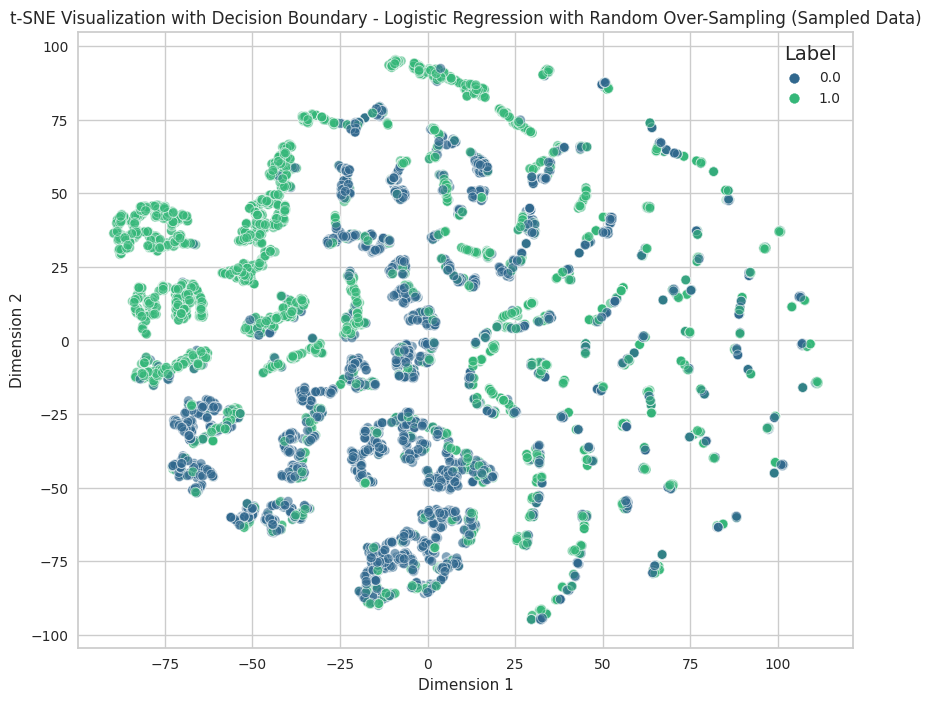

In [80]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Sample 10,000 data points for visualization
sample_size = 10000
sample_indices = np.random.choice(X_resampled.shape[0], size=sample_size, replace=False)

X_tsne_sample = X_resampled.iloc[sample_indices, :]
Y_tsne_sample = Y_resampled.iloc[sample_indices]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_tsne_sample)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Logistic Regression with Random Over-Sampling (Sampled Data)')
plt.show()


***2. Support Vector Machine (SVM) Classifier***

Accuracy: 0.5381717729784028

Confusion Matrix:
 [[1908   83]
 [1756  235]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.96      0.67      1991
           1       0.74      0.12      0.20      1991

    accuracy                           0.54      3982
   macro avg       0.63      0.54      0.44      3982
weighted avg       0.63      0.54      0.44      3982



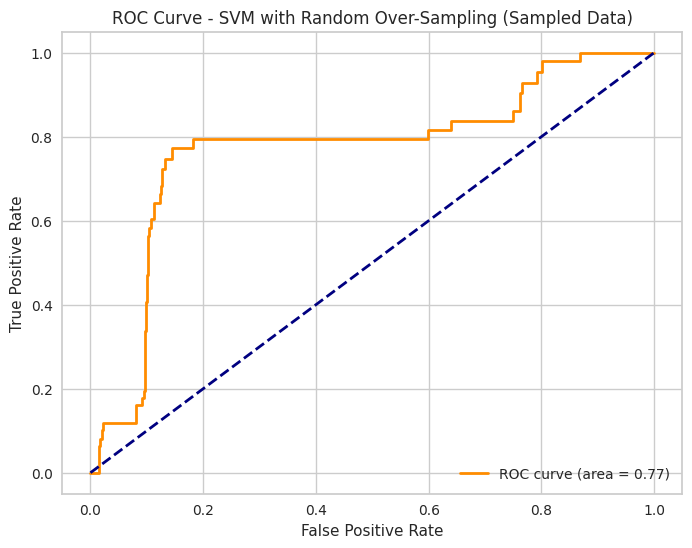

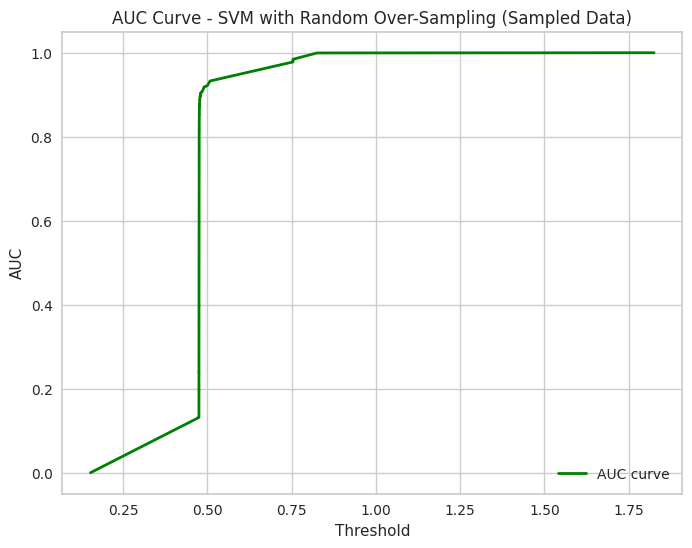

In [82]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Sample 10,000 data points for training and testing
sample_size = 10000
sample_indices = np.random.choice(total.shape[0], size=sample_size, replace=False)

total_sampled = total.iloc[sample_indices]

# Step 1: Handle imbalanced data using Random Over-Sampling
oversampler = RandomOverSampler(random_state=42)
X_resampled, Y_resampled = oversampler.fit_resample(total_sampled.drop('is_fraud', axis=1), total_sampled['is_fraud'])

# Step 2: Split the resampled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled)

# Step 3: Initialize and train the Support Vector Machine (SVM) classifier on the resampled data
svm_classifier = SVC(random_state=42, probability=True)
svm_classifier.fit(X_train, Y_train)

# Step 4: Make predictions on the test set
Y_pred = svm_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = svm_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM with Random Over-Sampling (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - SVM with Random Over-Sampling (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

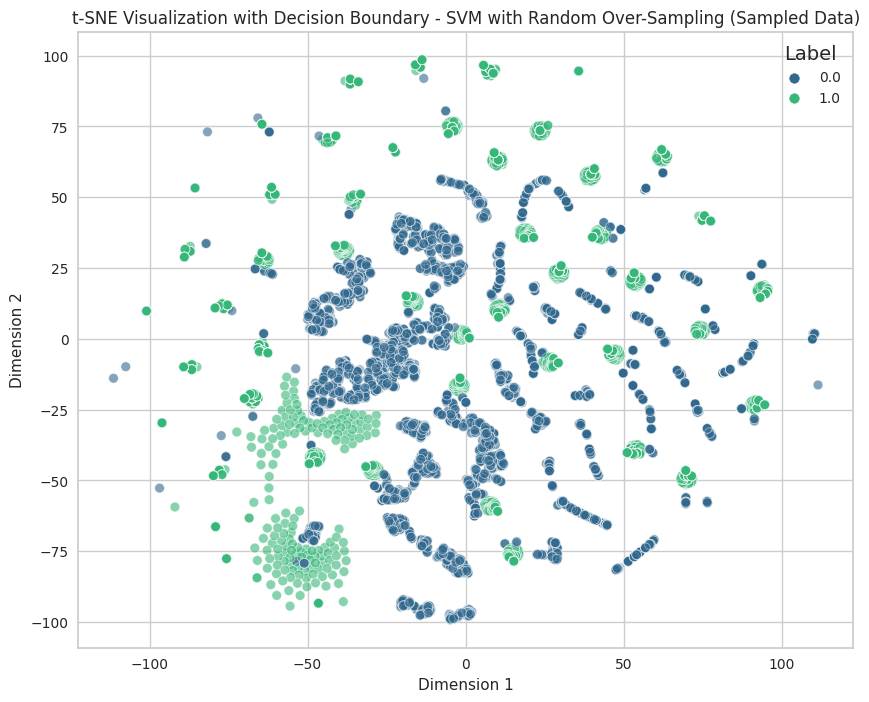

In [83]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_resampled.shape[0], size=sample_size_tsne, replace=False)

X_resampled_tsne = X_resampled.iloc[sample_indices_tsne, :]
Y_resampled_tsne = Y_resampled.iloc[sample_indices_tsne]

# Step 9: Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_tsne)  # Use the sampled data for visualization

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_resampled_tsne)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - SVM with Random Over-Sampling (Sampled Data)')
plt.show()

***3. K-nearest neighbor (KNN) Classifier***

Accuracy: 0.9925

Confusion Matrix:
 [[ 980   15]
 [   0 1005]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       995
           1       0.99      1.00      0.99      1005

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



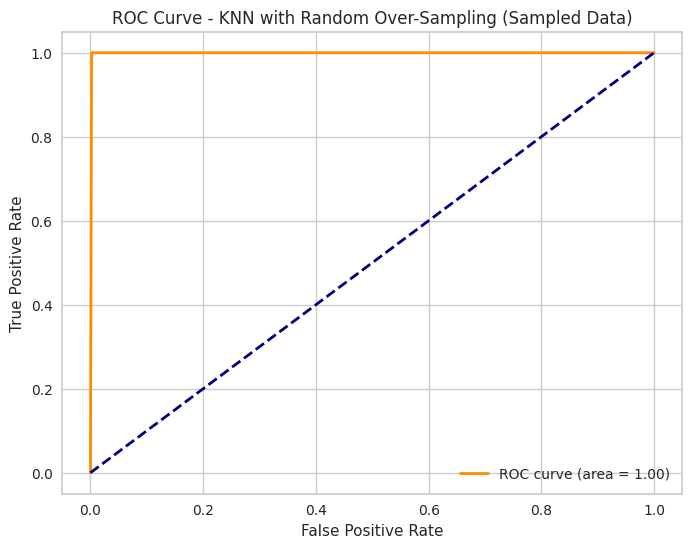

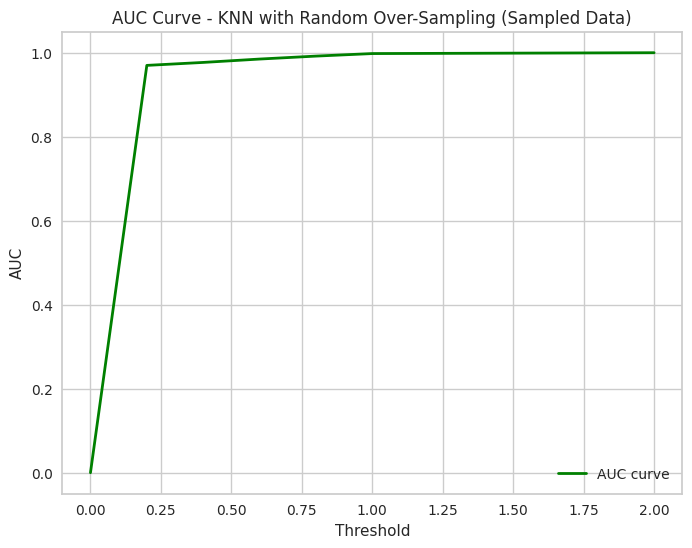

In [87]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Sample 10,000 data points for KNN classification
sample_size_knn = 10000
sample_indices_knn = np.random.choice(X_resampled.shape[0], size=sample_size_knn, replace=False)

X_resampled_knn = X_resampled.iloc[sample_indices_knn]
Y_resampled_knn = Y_resampled.iloc[sample_indices_knn]

# Split the sampled data into train and test sets
X_train_knn, X_test_knn, Y_train_knn, Y_test_knn = train_test_split(
    X_resampled_knn, Y_resampled_knn, test_size=0.2, random_state=42, stratify=Y_resampled_knn
)

# Initialize and train the K-nearest neighbor (KNN) classifier on the sampled data
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_knn, Y_train_knn)

# Make predictions on the test set
Y_pred_knn = knn_classifier.predict(X_test_knn)

# Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test_knn, Y_pred_knn))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test_knn, Y_pred_knn))
print("\nClassification Report:\n", classification_report(Y_test_knn, Y_pred_knn))

# Get the predicted probabilities for the positive class (fraud)
Y_pred_proba_knn = knn_classifier.predict_proba(X_test_knn)[:, 1]

# Calculate the ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(Y_test_knn, Y_pred_proba_knn)

# Calculate the AUC (Area Under the Curve)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_knn))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN with Random Over-Sampling (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds_knn, 1 - fpr_knn, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - KNN with Random Over-Sampling (Sampled Data)')
plt.legend(loc='lower right')
plt.show()

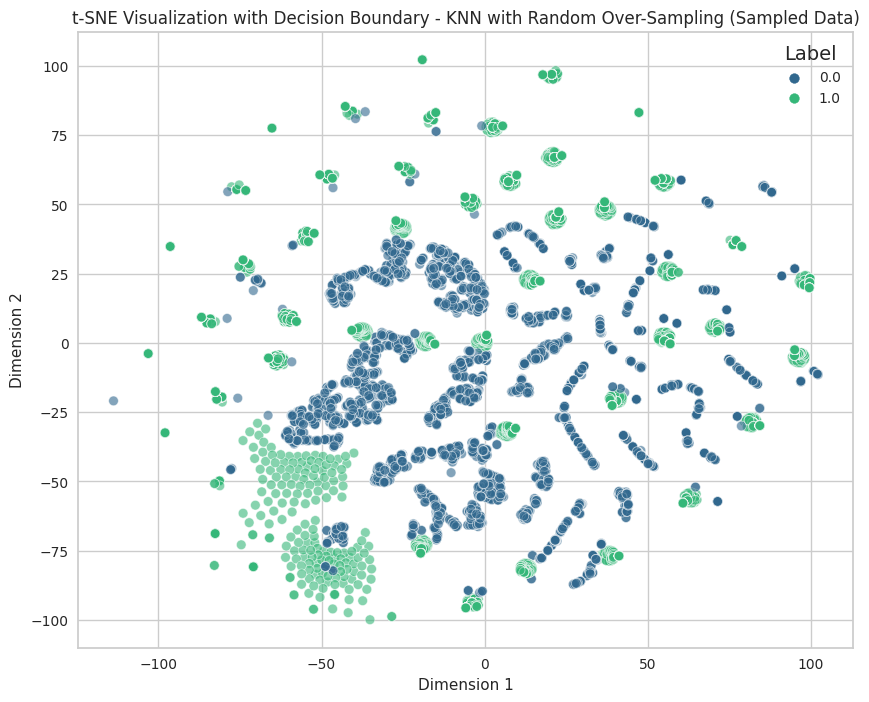

In [88]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_resampled.shape[0], size=sample_size_tsne, replace=False)

X_resampled_tsne = X_resampled.iloc[sample_indices_tsne, :]
Y_resampled_tsne = Y_resampled.iloc[sample_indices_tsne]

# Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_tsne)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_resampled_tsne)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - KNN with Random Over-Sampling (Sampled Data)')
plt.show()

***undersampling models***

***1. Decision Tree Classifier***

Accuracy: 0.9637399637399637

Confusion Matrix:
 [[1866   65]
 [  75 1855]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1931
           1       0.97      0.96      0.96      1930

    accuracy                           0.96      3861
   macro avg       0.96      0.96      0.96      3861
weighted avg       0.96      0.96      0.96      3861



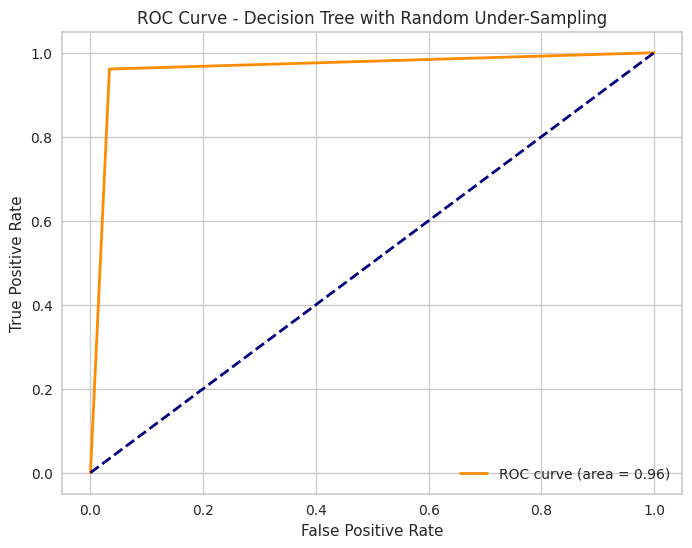

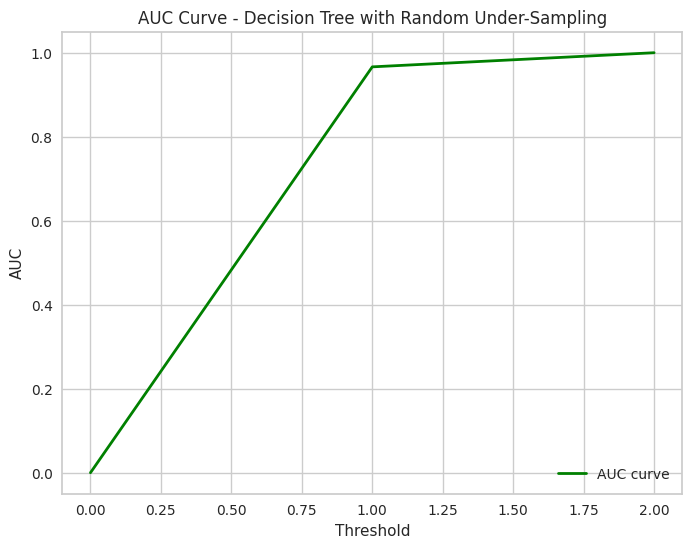

In [89]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Handle imbalanced data using Random Under-Sampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, Y_resampled = undersampler.fit_resample(total.drop('is_fraud', axis=1), total['is_fraud'])

# Step 2: Split the resampled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled)

# Step 3: Initialize and train the Decision Tree classifier on the resampled data
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, Y_train)

# Step 4: Make predictions on the test set
Y_pred = dt_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Decision Tree with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()


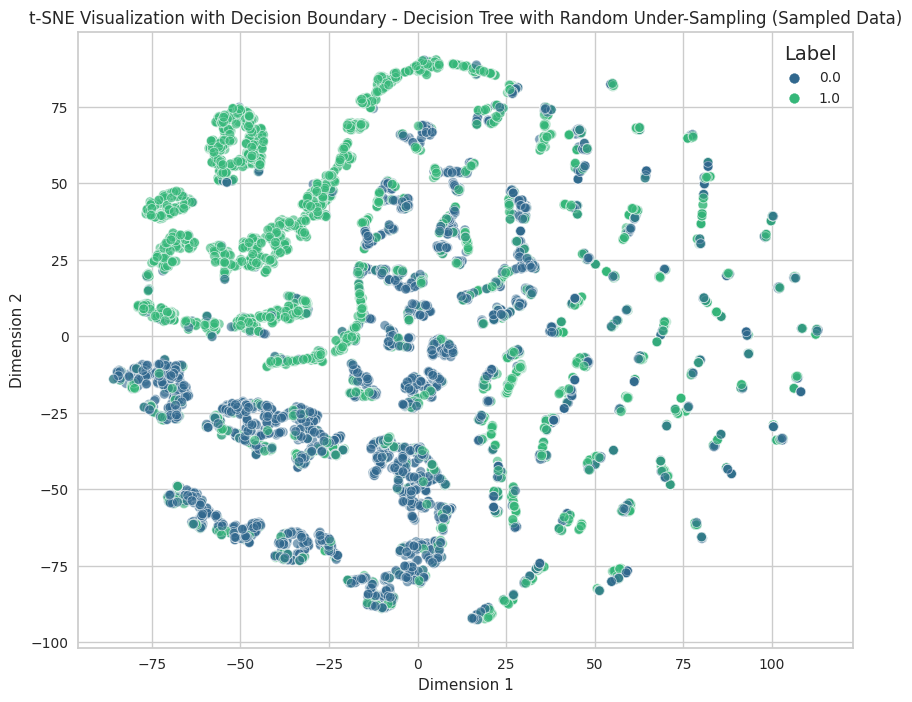

In [90]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_resampled.shape[0], size=sample_size_tsne, replace=False)

X_resampled_tsne = X_resampled.iloc[sample_indices_tsne, :]
Y_resampled_tsne = Y_resampled.iloc[sample_indices_tsne]

# Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_tsne)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_resampled_tsne)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Decision Tree with Random Under-Sampling (Sampled Data)')
plt.show()

***2. Random Forest Classifier***

Accuracy: 0.9746179746179746

Confusion Matrix:
 [[1895   36]
 [  62 1868]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1931
           1       0.98      0.97      0.97      1930

    accuracy                           0.97      3861
   macro avg       0.97      0.97      0.97      3861
weighted avg       0.97      0.97      0.97      3861



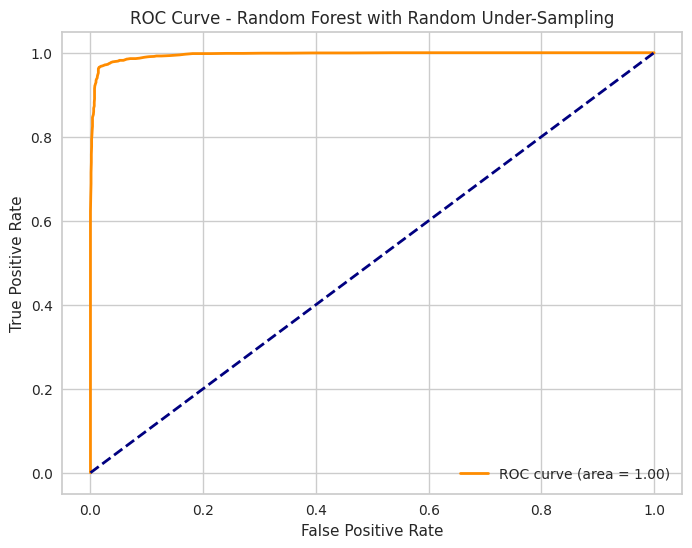

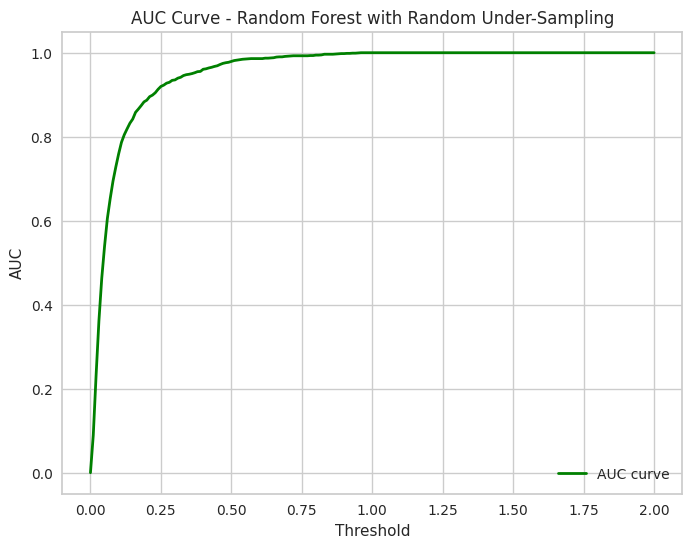

In [91]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Handle imbalanced data using Random Under-Sampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, Y_resampled = undersampler.fit_resample(total.drop('is_fraud', axis=1), total['is_fraud'])

# Step 2: Split the resampled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled)

# Step 3: Initialize and train the Random Forest classifier on the resampled data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, Y_train)

# Step 4: Make predictions on the test set
Y_pred = rf_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Random Forest with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()

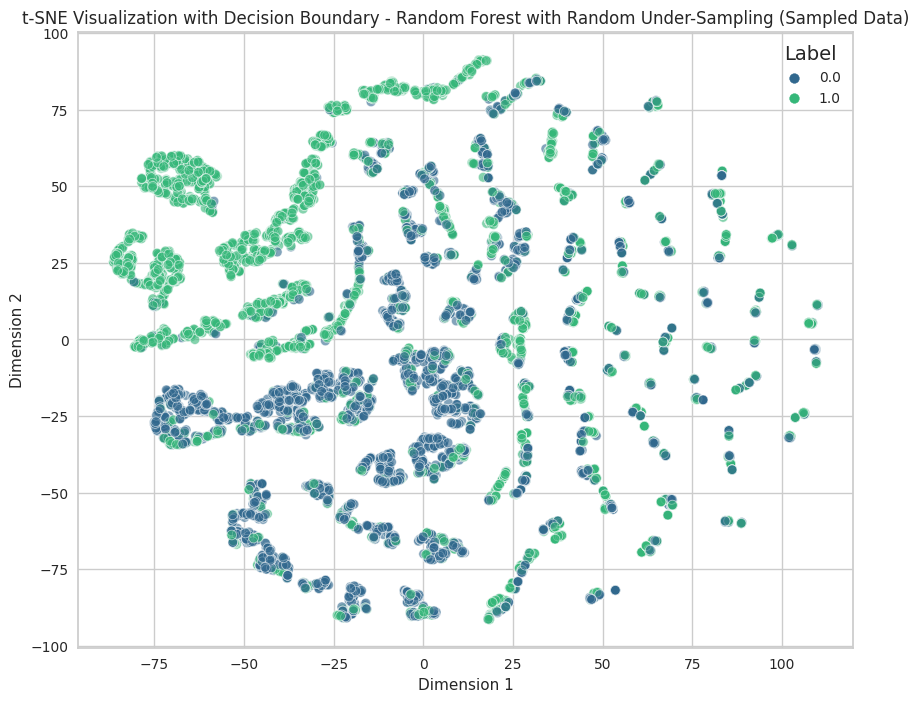

In [92]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_resampled.shape[0], size=sample_size_tsne, replace=False)

X_resampled_tsne = X_resampled.iloc[sample_indices_tsne, :]
Y_resampled_tsne = Y_resampled.iloc[sample_indices_tsne]

# Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_tsne)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_resampled_tsne)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Random Forest with Random Under-Sampling (Sampled Data)')
plt.show()

***3. Naive Bayes***

Accuracy: 0.8451178451178452

Confusion Matrix:
 [[1868   63]
 [ 535 1395]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.97      0.86      1931
           1       0.96      0.72      0.82      1930

    accuracy                           0.85      3861
   macro avg       0.87      0.85      0.84      3861
weighted avg       0.87      0.85      0.84      3861



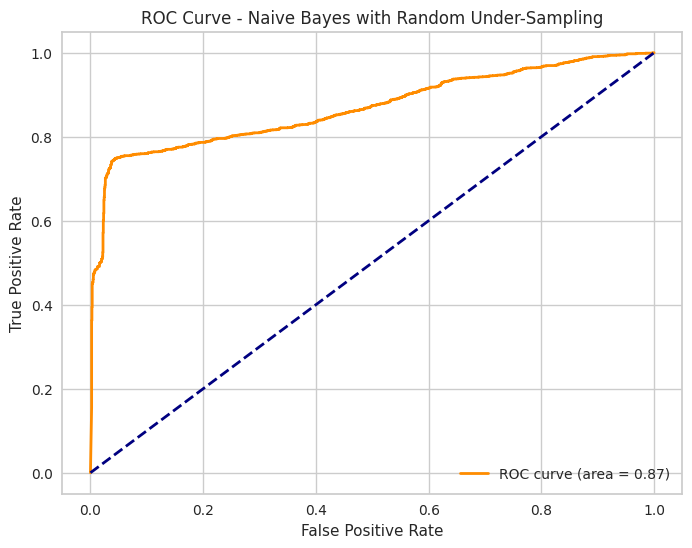

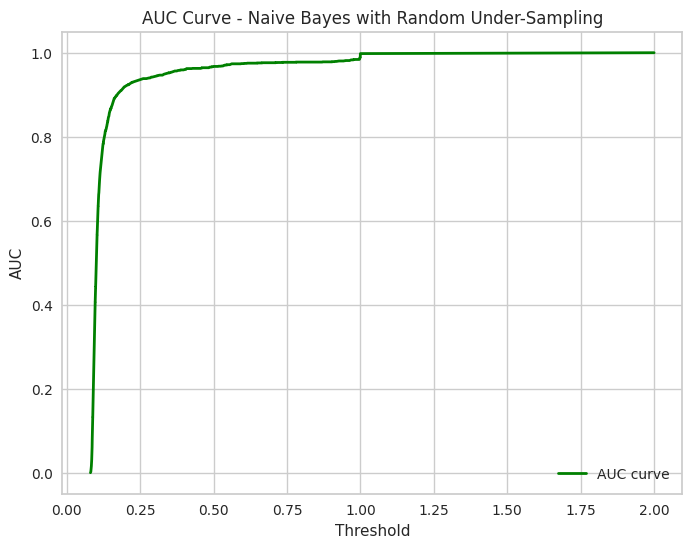

In [93]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Handle imbalanced data using Random Under-Sampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, Y_resampled = undersampler.fit_resample(total.drop('is_fraud', axis=1), total['is_fraud'])

# Step 2: Split the resampled data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42, stratify=Y_resampled)

# Step 3: Initialize and train the Naive Bayes classifier on the resampled data
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, Y_train)

# Step 4: Make predictions on the test set
Y_pred = nb_classifier.predict(X_test)

# Step 5: Evaluate the performance of the model
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Step 6: Get the predicted probabilities for the positive class (fraud)
Y_pred_proba = nb_classifier.predict_proba(X_test)[:, 1]

# Step 7: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

# Step 8: Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()

# Plot the AUC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, 1 - fpr, color='green', lw=2, label='AUC curve')
plt.xlabel('Threshold')
plt.ylabel('AUC')
plt.title('AUC Curve - Naive Bayes with Random Under-Sampling')
plt.legend(loc='lower right')
plt.show()


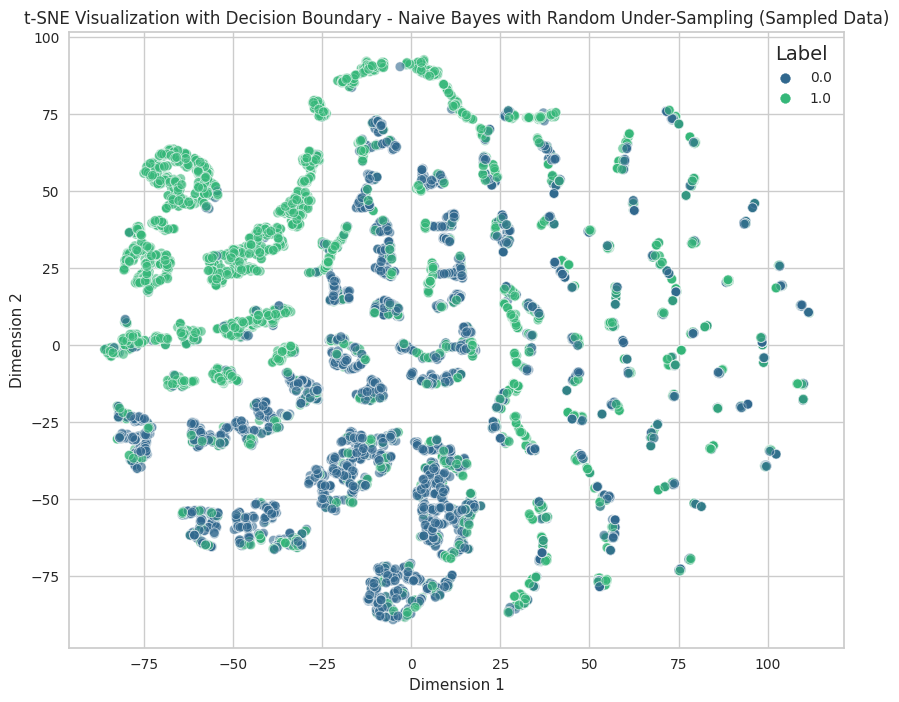

In [94]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np

# Sample 10,000 data points for t-SNE visualization
sample_size_tsne = 10000
sample_indices_tsne = np.random.choice(X_resampled.shape[0], size=sample_size_tsne, replace=False)

X_resampled_tsne = X_resampled.iloc[sample_indices_tsne, :]
Y_resampled_tsne = Y_resampled.iloc[sample_indices_tsne]

# Apply t-SNE to visualize decision boundary
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_resampled_tsne)

# Create a DataFrame with t-SNE results and corresponding labels
tsne_df = pd.DataFrame(data=np.column_stack((X_tsne, Y_resampled_tsne)), columns=['Dimension 1', 'Dimension 2', 'Label'])

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Label', data=tsne_df, palette='viridis', alpha=0.6)
plt.title('t-SNE Visualization with Decision Boundary - Naive Bayes with Random Under-Sampling (Sampled Data)')
plt.show()

-----

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import HalvingRandomSearchCV,RandomizedSearchCV